In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from collections import namedtuple

ENV='CartPole-v0'
gamma=0.99
max_step=200
max_episode=500
lr=0.5
Transition=namedtuple('Transition',('state','action','next_state','reward'))

batch_size=32
capacity=10000

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0,frames[0].shape[0]/72.0),dpi=72.0)
    patch=plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim=animation.FuncAnimation(plt.gcf(),animate,frames=len(frames),interval=50)
    anim.save('cartpole-DDQN.mp4')
    display(display_animation(anim,default_mode='loop'))

In [37]:
#経験を保存するクラス
"""経験を保存する、経験を取り出すこと
   capacity:容量"""
class ReplayMemory():
    def __init__(self,capacity):
        self.capacity=capacity
        self.memory=[]
        self.index=0
        
    def push(self,state,action,next_state,reward):
        #容量オーバーの時は何も加えない
        if len(self.memory)<self.capacity:
            self.memory.append(None)
        self.memory[self.index]=Transition(state,action,next_state,reward)
        self.index=(self.index+1)%self.capacity
        
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

In [38]:
#deep newral network class
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    """入力層、中間層、出力層を設定"""
    def __init__(self,n_in,n_mid,n_out):
        super(Net,self).__init__()
        self.fc1=nn.Linear(n_in,n_mid)
        self.fc2=nn.Linear(n_mid,n_mid)
        self.fc3=nn.Linear(n_mid,n_out)
    #順伝播    
    def forward(self,x):
        h1=F.relu(self.fc1(x))
        h2=F.relu(self.fc2(h1))
        output=self.fc3(h2)
        return output
        

In [55]:
#class brain
"""init,replay,decide_action
   num_states:変数の個数
   num_actions:行動の選択の個数"""
from torch import optim
from torch import nn
import random
class Brain():
    
    def __init__(self,num_states,num_actions):
        self.memory=ReplayMemory(capacity)
        self.num_actions=num_actions
        
        #main,targetのそれぞれのq-networkを作成
        n_in,n_mid,n_out=num_states,32,num_actions
        self.main_q_network=Net(n_in,n_mid,n_out)
        self.target_q_network=Net(n_in,n_mid,n_out)
        #ネットワークモデルの可視化
        print(self.main_q_network)
        
        #最適化指標
        self.optimizer=optim.Adam(self.main_q_network.parameters(),lr=0.0001)
        
    def replay(self):
        if len(self.memory)<batch_size:
            return
        #make_minibatch()
        self.batch,self.state_batch,self.action_batch,self.reward_batch,self.non_final_next_state=self.make_minibatch()
        #target_q_networkによるq_value(state_Action_values)の算出
        self.expected_state_action_values=self.compute_q_val()
        #update_q_func():main & target
        self.update_main_q_network()
        
        
    def decide_action(self,state,episode):
        epsilon=0.5*(1/(episode+1))
        
        if np.random.rand()<epsilon:
            action=torch.LongTensor([[random.randrange(self.num_actions)]])
            
            
        else:
            self.main_q_network.eval()
            with torch.no_grad():
                #インデックスを取り出して1*1のテンソルに直す
                action=self.main_q_network(state).max(1)[1].view(1,1)
                
        return action
        
        
        
    def make_minibatch(self):
        transitions=self.memory.sample(batch_size)
        
        batch=Transition(*zip(*transitions))
        
        state_batch=torch.cat(batch.state)
        action_batch=torch.cat(batch.action)
        reward_batch=torch.cat(batch.reward)
        
        non_final_next_state=torch.cat([s for s in batch.next_state if s is not None])
        
        return batch,state_batch,action_batch,reward_batch,non_final_next_state
    def compute_q_val(self):
        #推論モード
        self.main_q_network.eval()
        self.target_q_network.eval()
        
        self.state_action_values=self.main_q_network(self.state_batch).gather(1,self.action_batch)
        
        non_final_mask=torch.ByteTensor(tuple(map(lambda x:x is not None,self.batch.next_state)))
        
        #初期化
        next_state_values=torch.zeros(batch_size)
        #next_q_valsを最大にする行動
        a_m=torch.zeros(batch_size).type(torch.LongTensor)
        
        #maxQの行動のインデックスを求める
        a_m[non_final_mask]=self.main_q_network(self.non_final_next_state).detach().max(1)[1]
        
        #次の状態があるものだけを通して32*1 tensorに
        a_m_non_fina_next_state=a_m[non_final_mask].view(-1,1)
        
        next_state_values[non_final_mask]=self.target_q_network(self.non_final_next_state).gather(1,a_m_non_fina_next_state).detach().squeeze()
        
        expected_state_action_values=self.reward_batch+gamma*next_state_values
        
        return expected_state_action_values
    
    def update_main_q_network(self):
        self.main_q_network.train()
        loss=F.smooth_l1_loss(self.state_action_values,self.expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_q_network(self):
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())
        
        

In [56]:
#agent
"""update_q(main,target),get_action,memorize,"""

class Agent():
    def __init__(self,num_states,num_actions):
        self.brain=Brain(num_states,num_actions)
        
    def update_q_func(self):
        self.brain.replay()
        
    def get_action(self,state,episode):
        action=self.brain.decide_action(state,episode)
        return action
    
    def memorize(self,state,action,next_state,reward):
        self.brain.memory.push(state,action,next_state,reward)
        
        
    def update_target_q_func(self):
        self.brain.update_target_q_network()

In [57]:
#environment
"""init,run"""
class Environment():
    def __init__(self):
        self.env=gym.make(ENV)
        num_states=self.env.observation_space.shape[0]
        num_actions=self.env.action_space.n
        
        self.agent=Agent(num_states,num_actions)
        
    def run(self):
        complete_episode=0
        terminal=False
        frames=[]
        
        episode_10_list=np.zeros(10)
        
        for episode in range(max_episode):
            observation=self.env.reset()
            state=observation
            state=torch.from_numpy(state).type(torch.FloatTensor)
            state=torch.unsqueeze(state,0)
            
            for step in range(max_step):
                if terminal is True:
                    frames.append(self.env.render(mode='rgb_array'))
                    
                action=self.agent.get_action(state,episode)
                
                observation_next,_,done,_=self.env.step(action.item())
                
                if done:
                    next_state=None
                    
                    episode_10_list=np.hstack((episode_10_list[1:],step+1))
                    
                    if step<195:
                        reward=torch.FloatTensor([-1.0])
                        complete_episode=0#連続をリセット
                        
                    else:
                        reward=torch.FloatTensor([1.0])
                        complete_episode+=1
                        
                else:
                    reward=torch.FloatTensor([0.0])
                    next_state=observation_next
                    next_state=torch.from_numpy(next_state).type(torch.FloatTensor)
                    next_state=torch.unsqueeze(next_state,0)
                #agentの脳みその中にぶち込んでいく   
                self.agent.memorize(state,action,next_state,reward)
                
                self.agent.update_q_func()
                
                #状態の更新
                state=next_state
                
                #終了したとき処理
                if done:
                    print('%d Episode: Finished after %d steps: average%.2f'%(episode,step+1,episode_10_list.mean()))
                    if episode%2==0:
                        self.agent.update_target_q_func()
                    break
                    
            if terminal is True:
                display_frames_as_gif(frames)
                break
            
            if complete_episode>=10:
                print('success')
                terminal=True
                    
                    
                

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 13 steps: average1.30
1 Episode: Finished after 10 steps: average2.30
2 Episode: Finished after 10 steps: average3.30
3 Episode: Finished after 9 steps: average4.20
4 Episode: Finished after 10 steps: average5.20
5 Episode: Finished after 9 steps: average6.10
6 Episode: Finished after 10 steps: average7.10
7 Episode: Finished after 10 steps: average8.10
8 Episode: Finished after 10 steps: average9.10
9 Episode: Finished after 9 steps: average10.00
10 Episode: Finished after 11 steps: average9.80
11 Episode: Finished after 10 steps: average9.80
12 Episode: Finished after 12 steps: average10.00
13 Episode: Finished after 10 steps: average10.10
14 Episode: Finished after 10 steps: ave


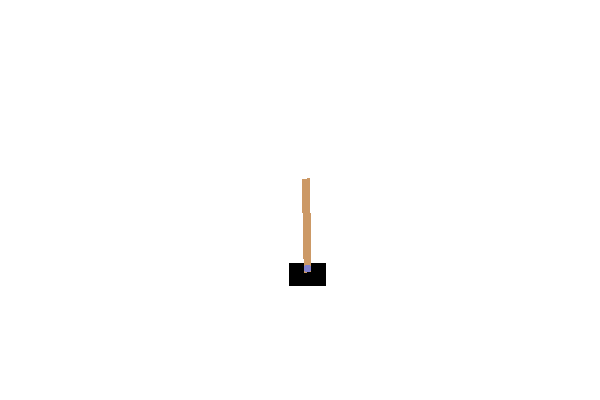
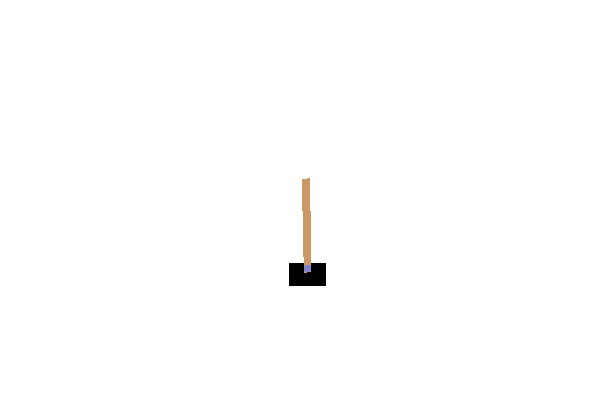
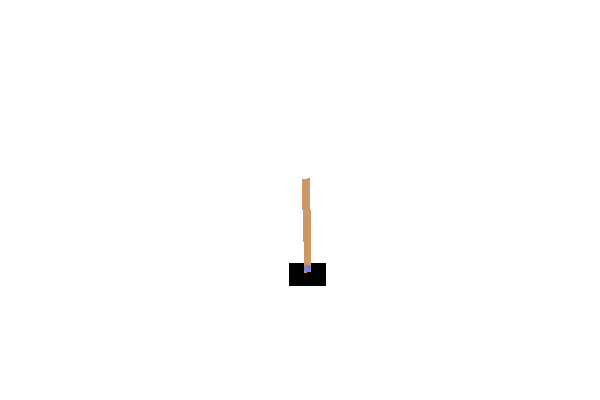
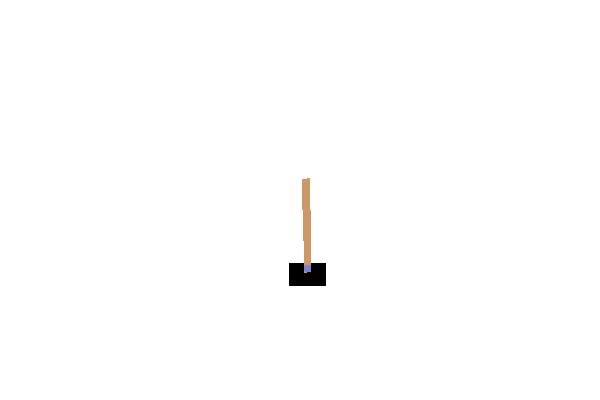
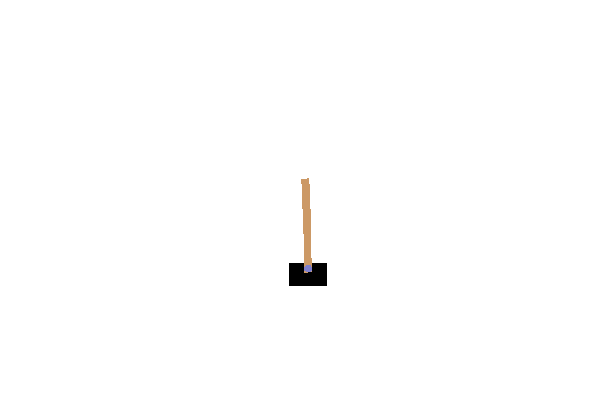
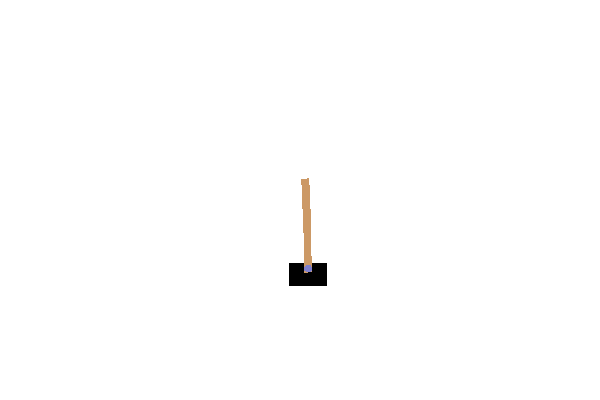
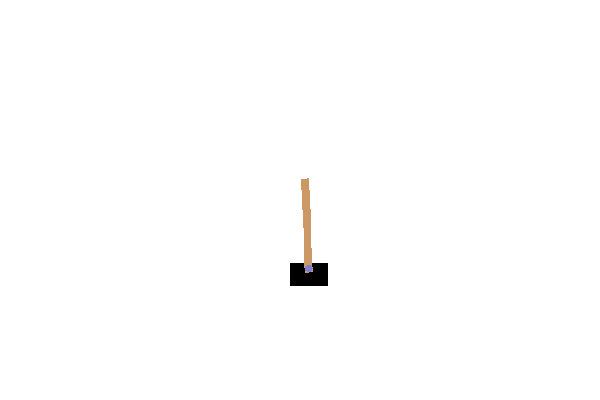
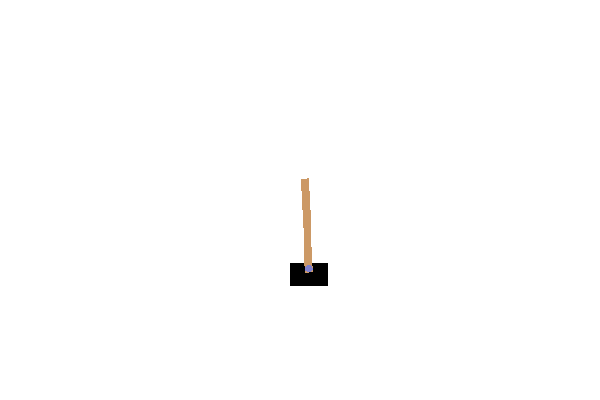
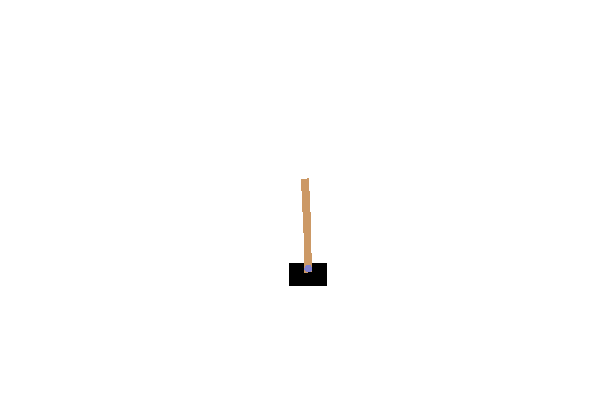
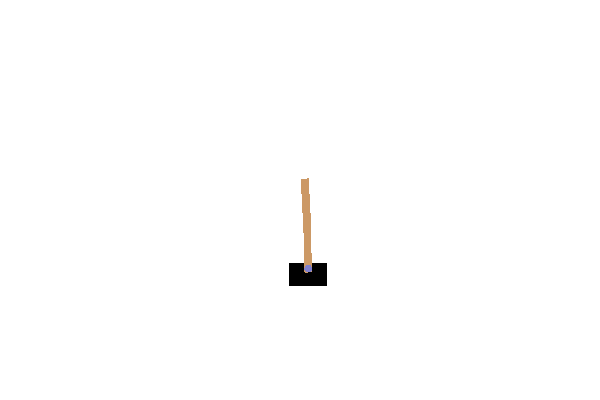
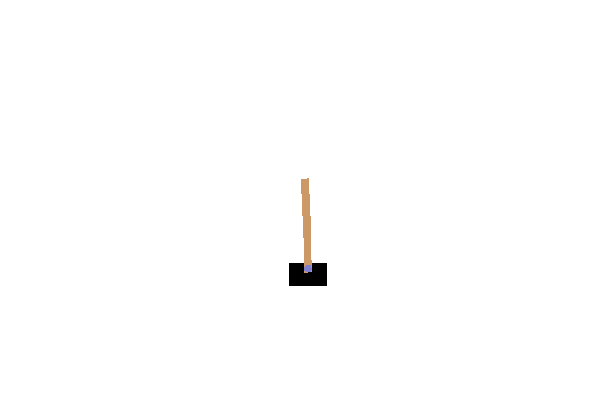
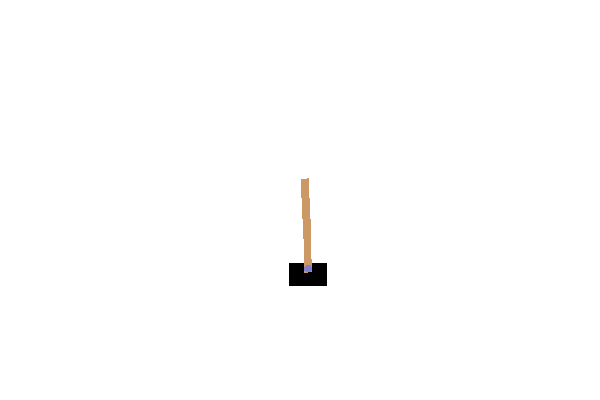
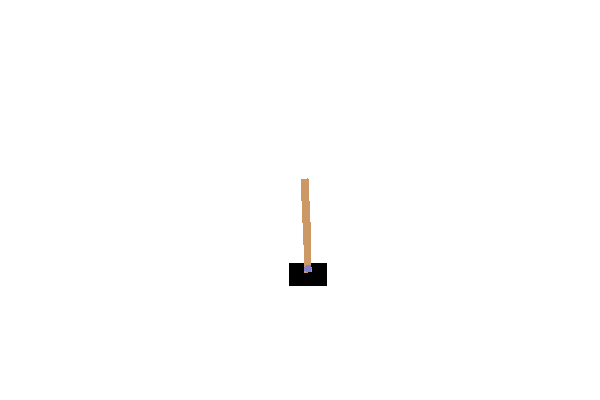
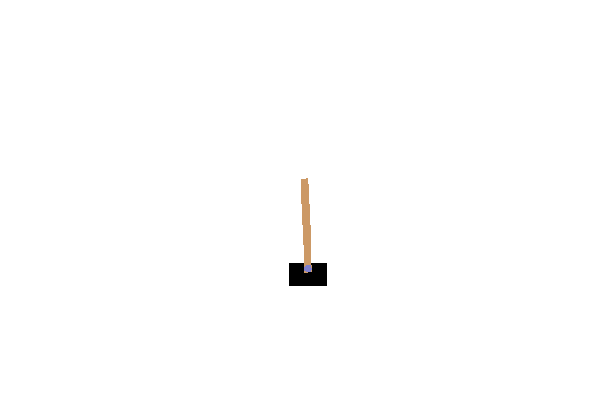
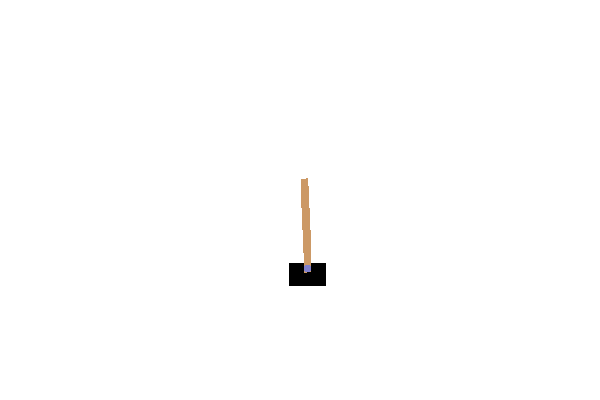
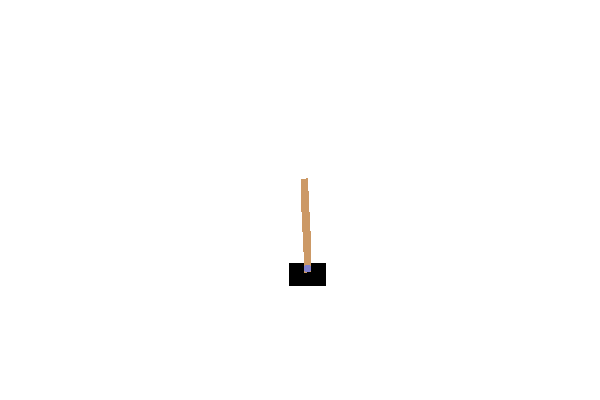
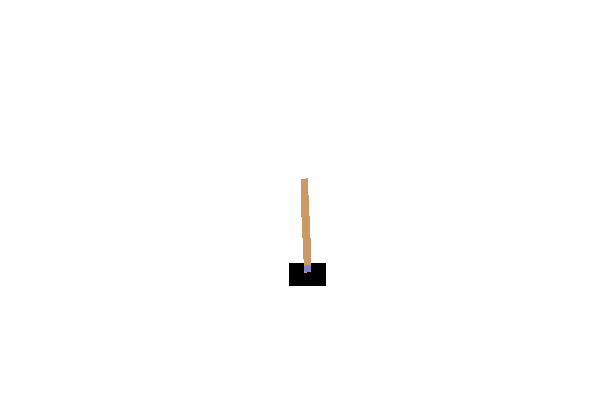
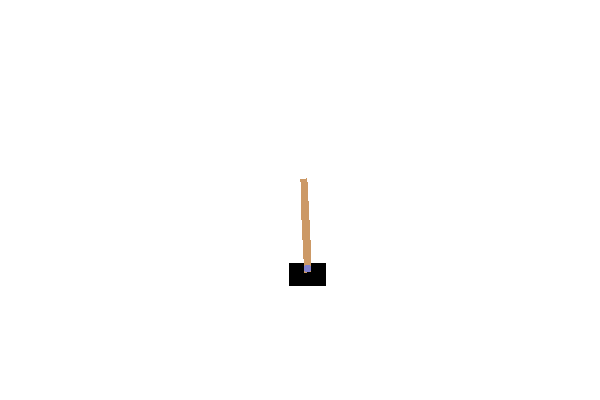
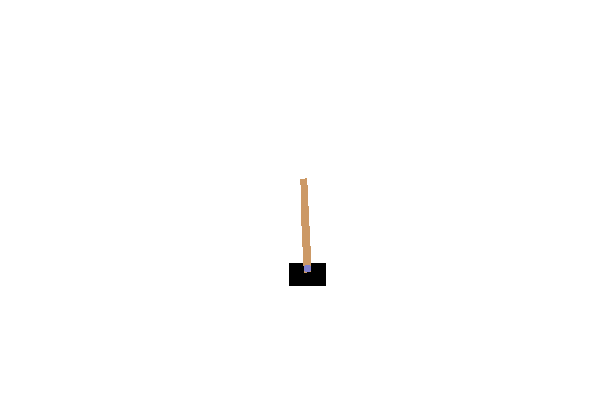
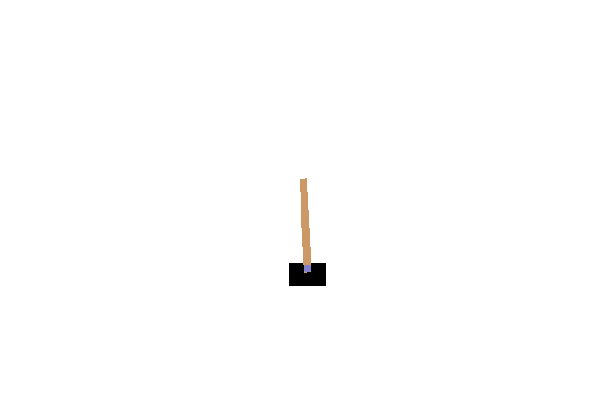
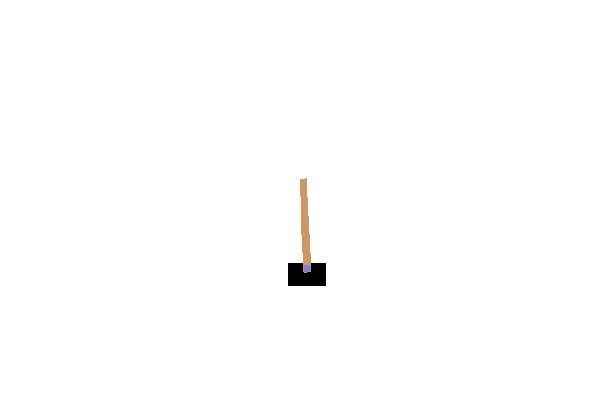
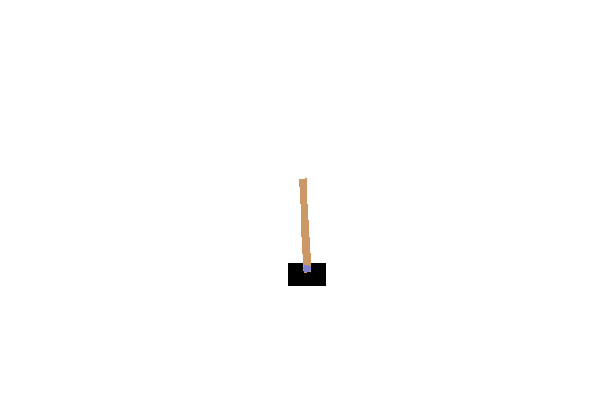
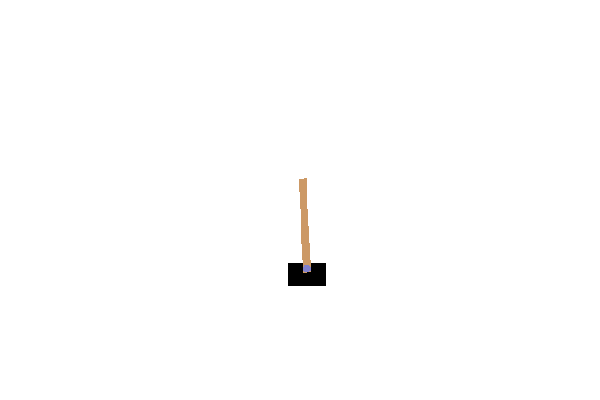
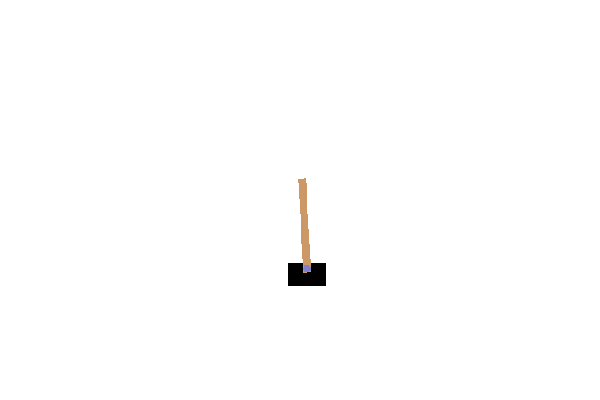
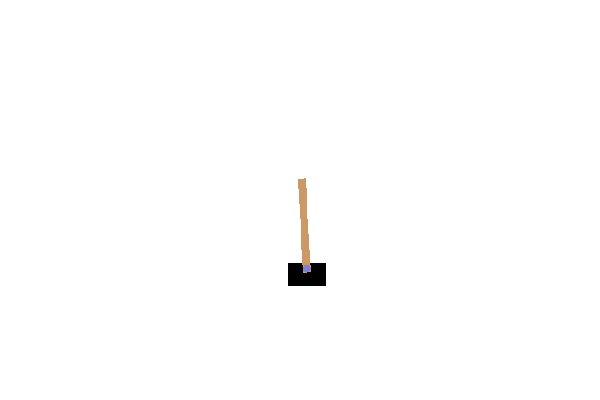
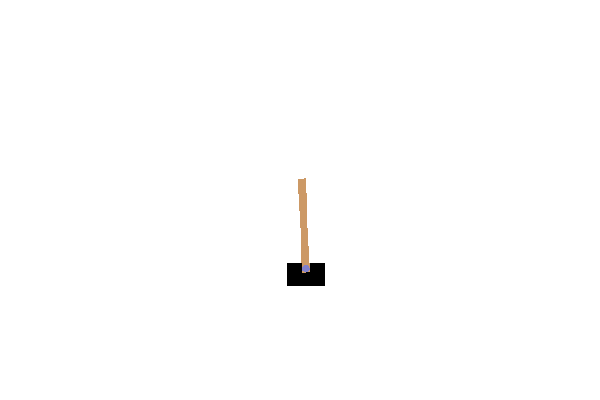
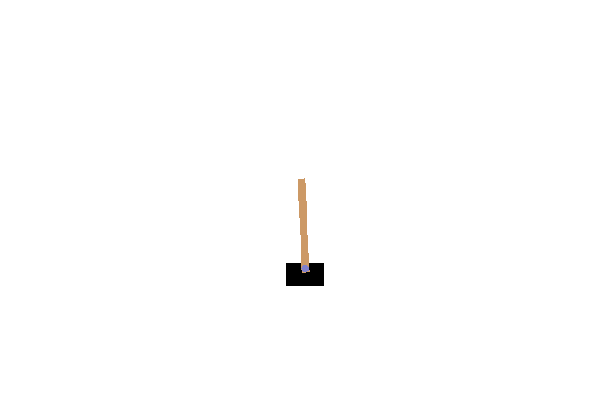
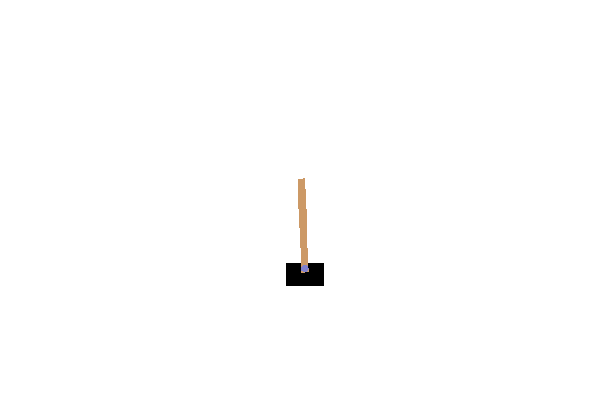
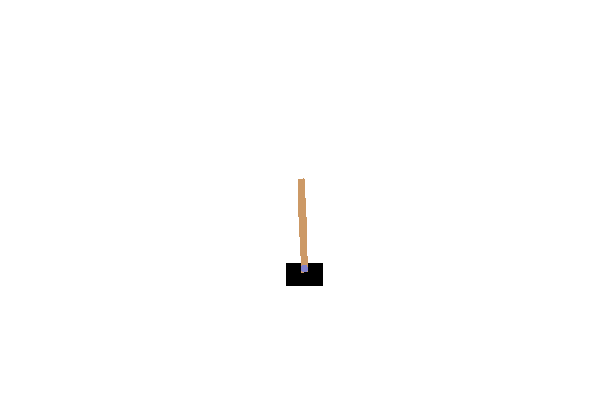
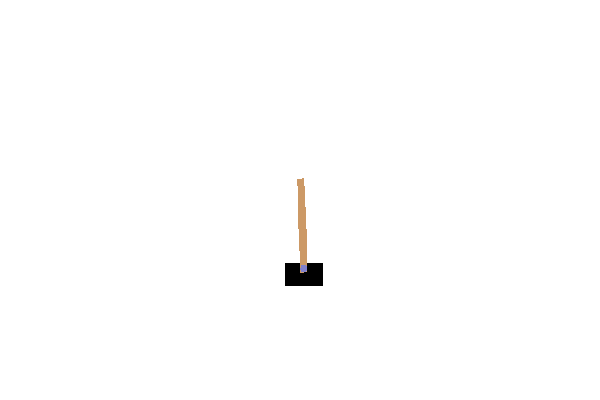
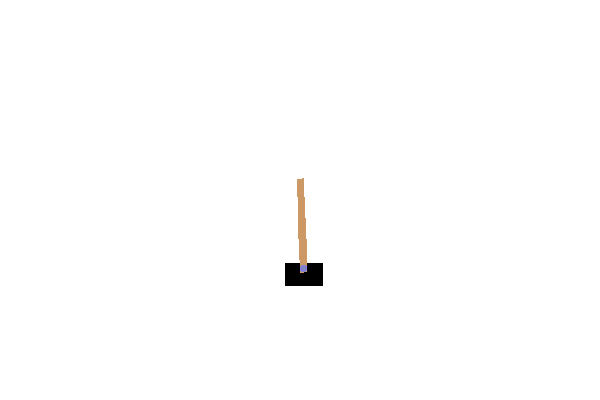
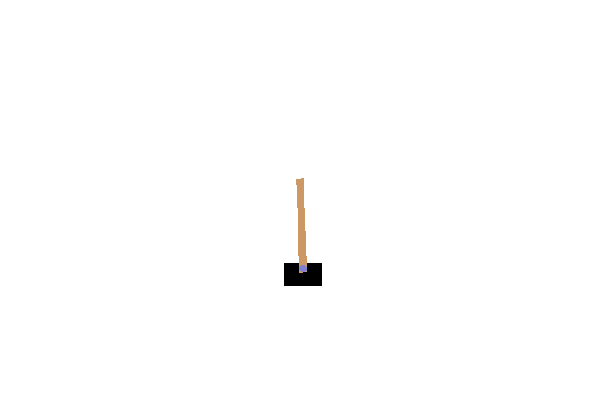
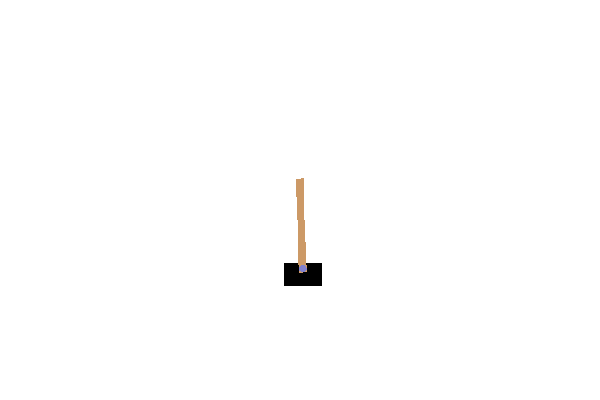
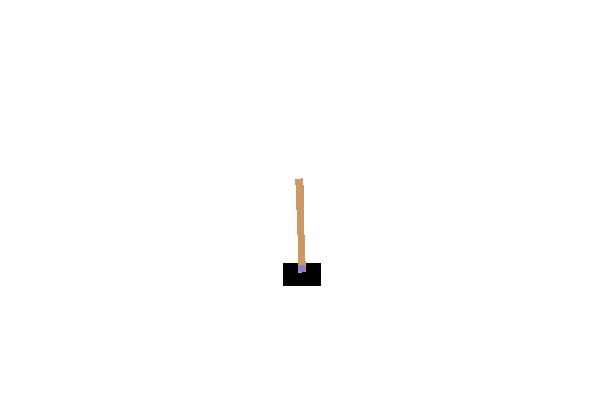
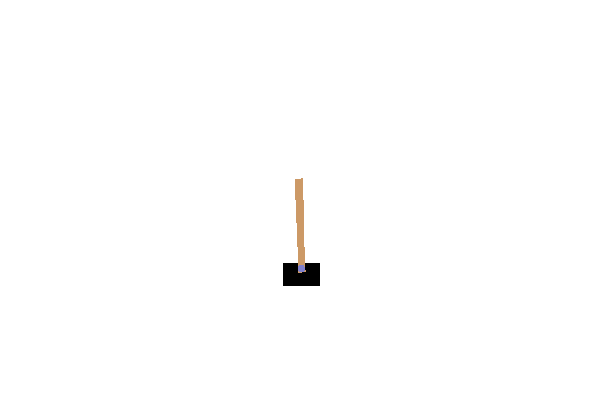
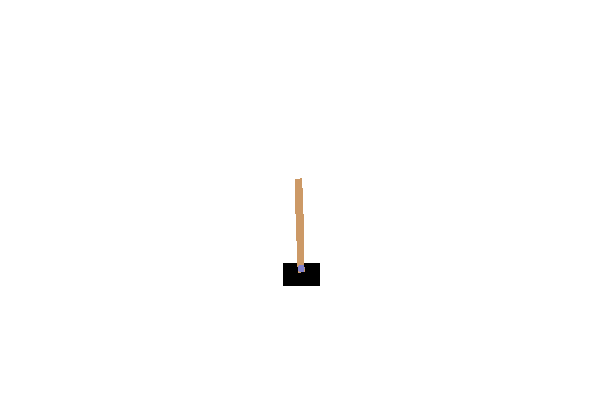
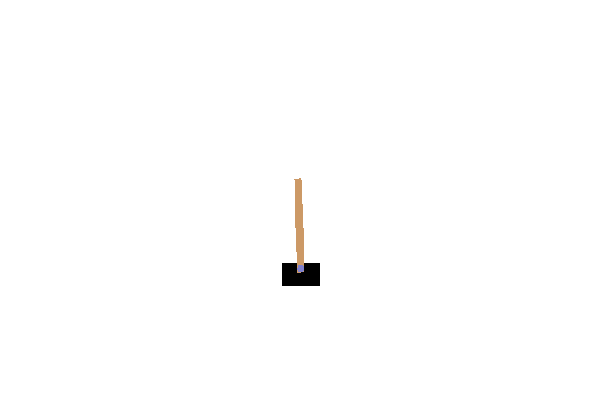
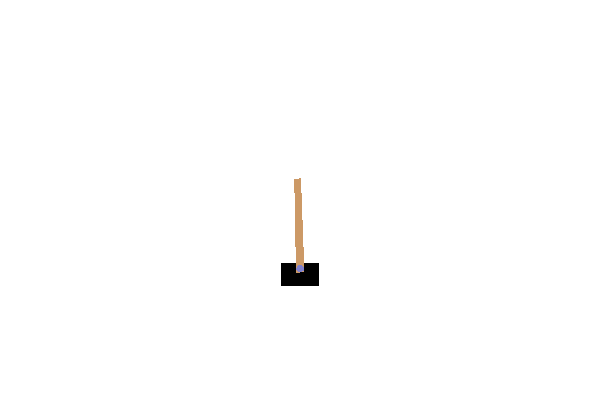
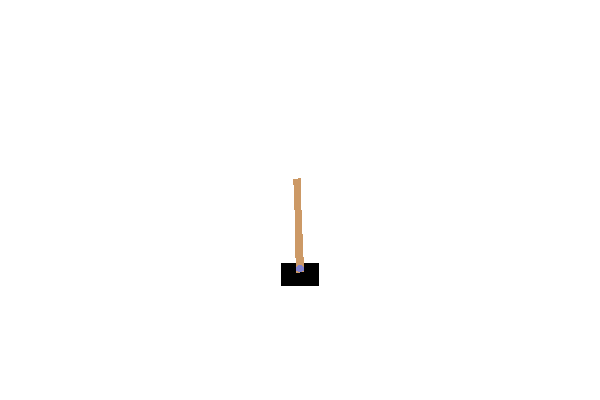
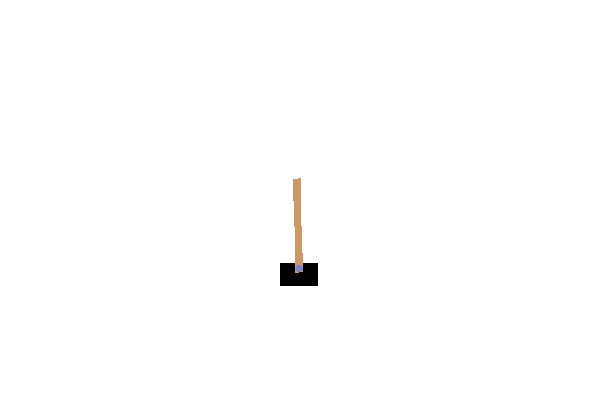
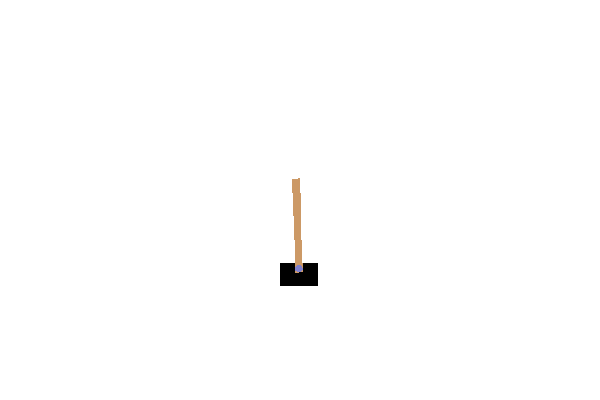
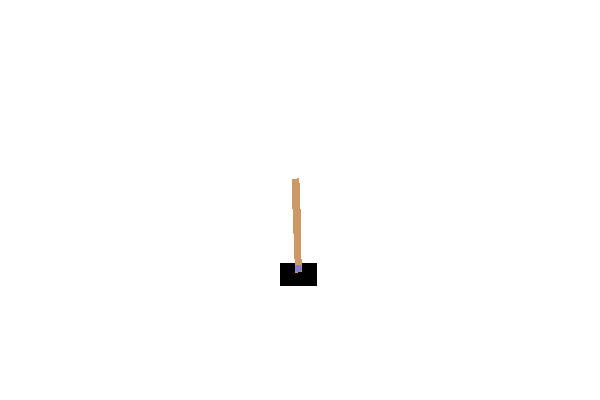
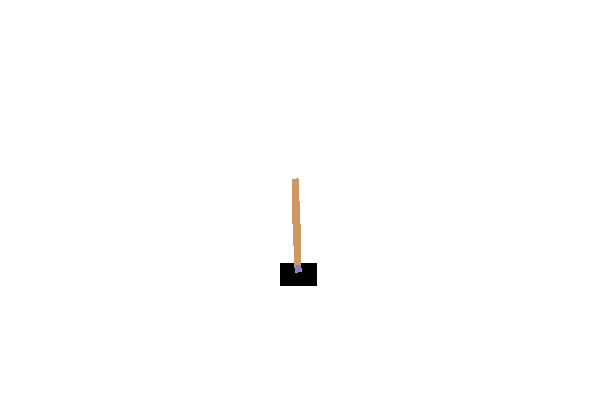
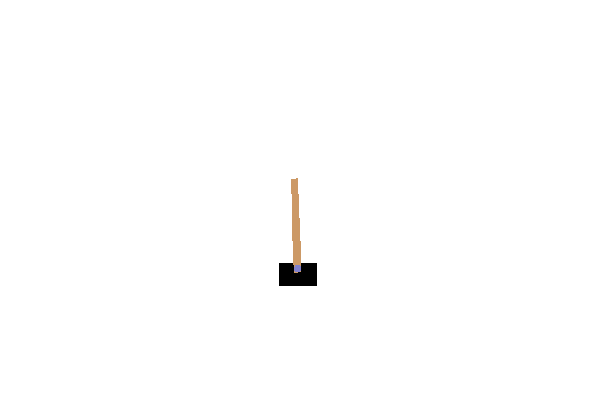
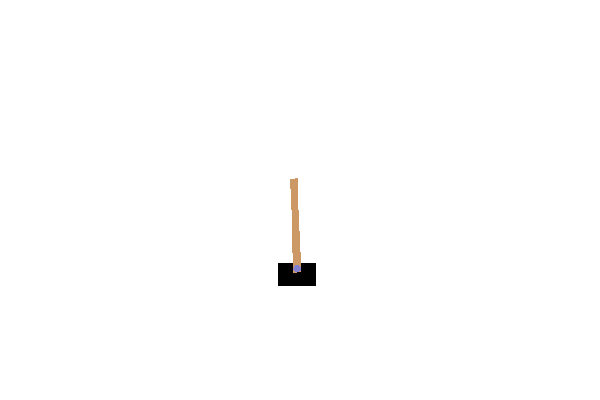
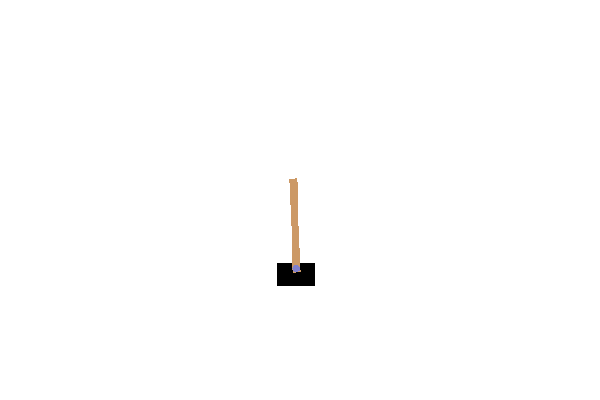
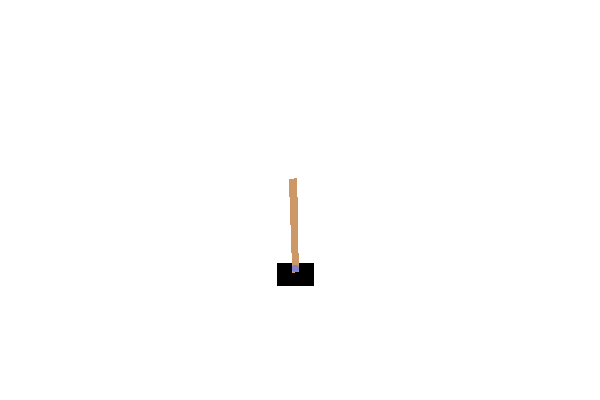
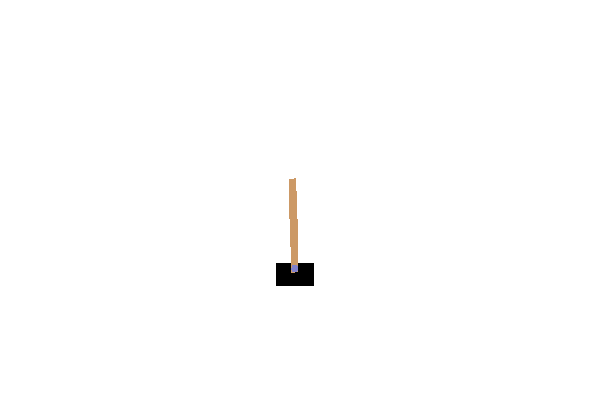
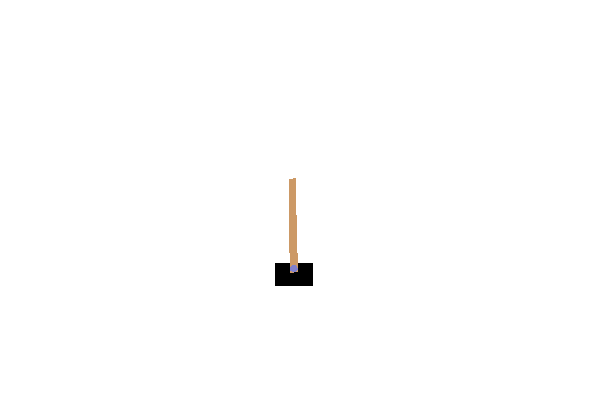
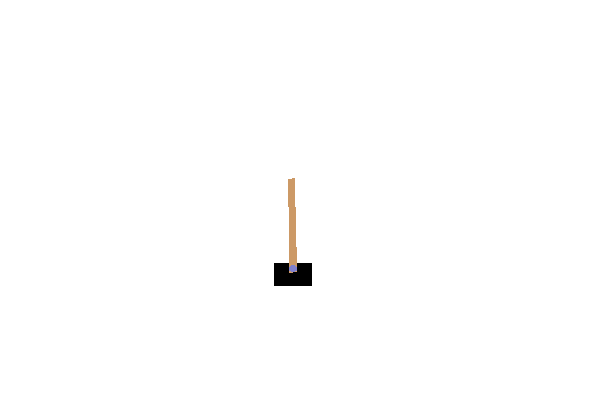
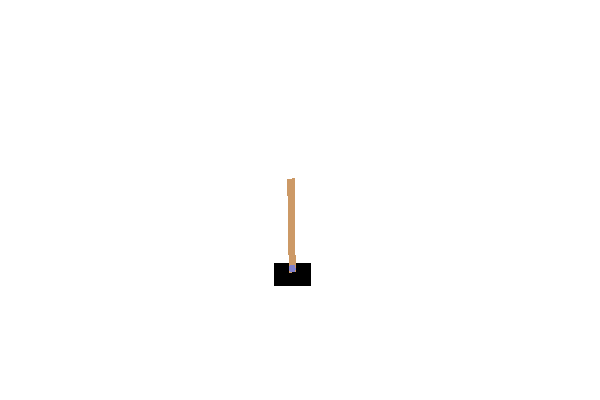
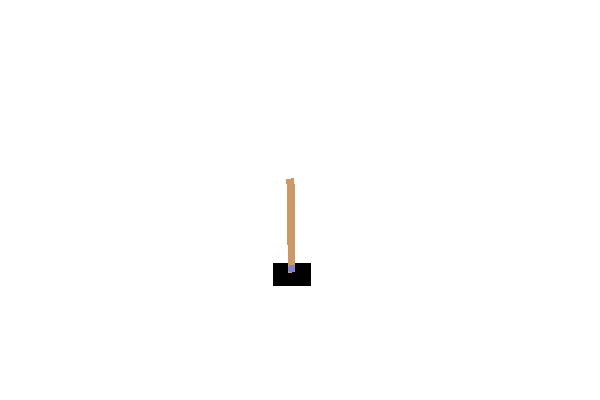
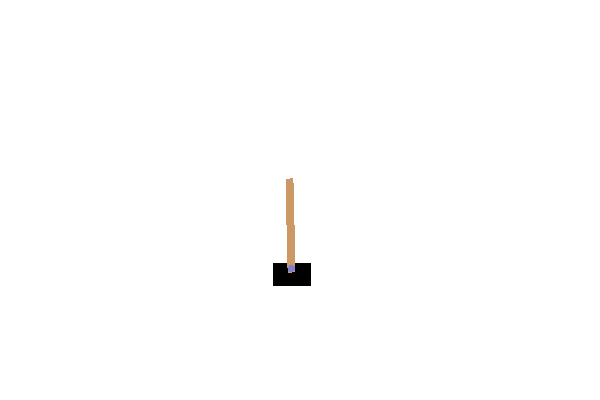
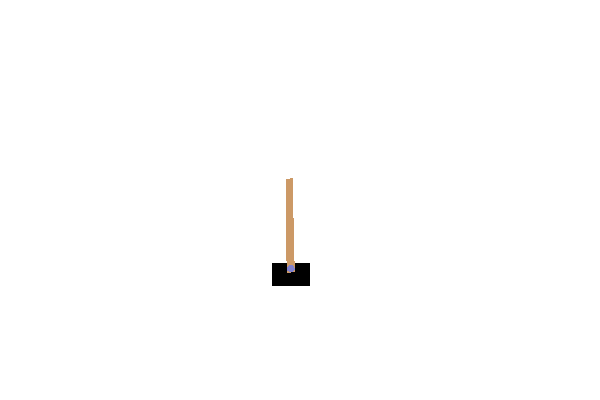
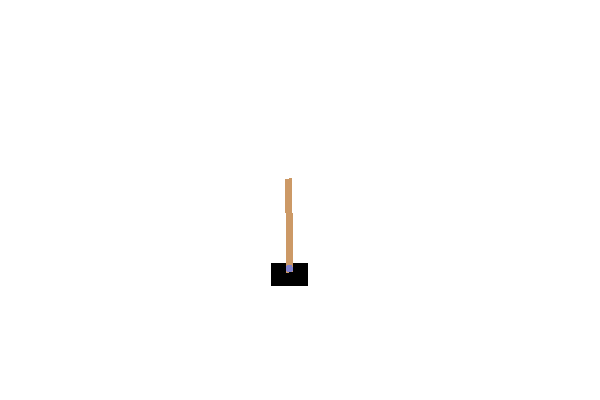
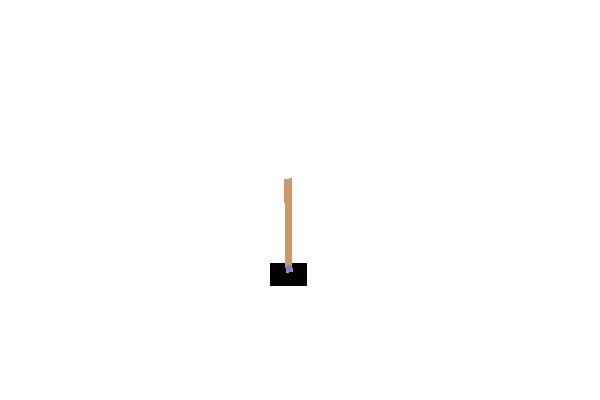
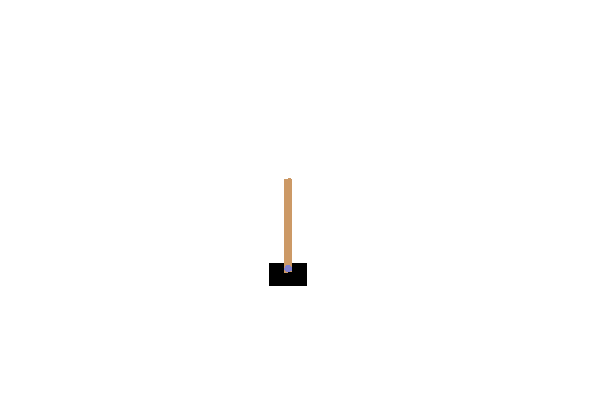
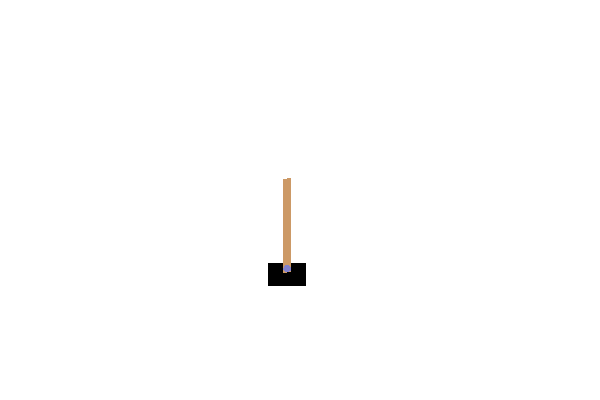
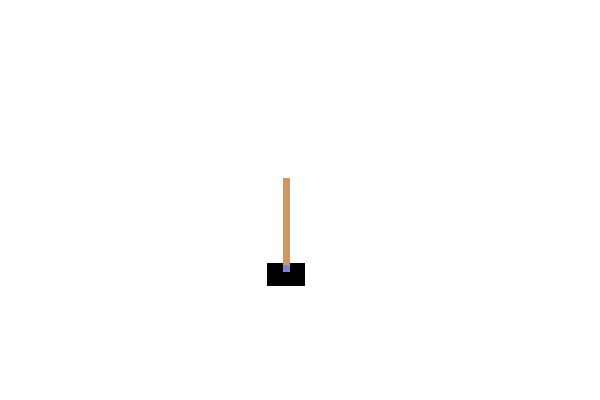
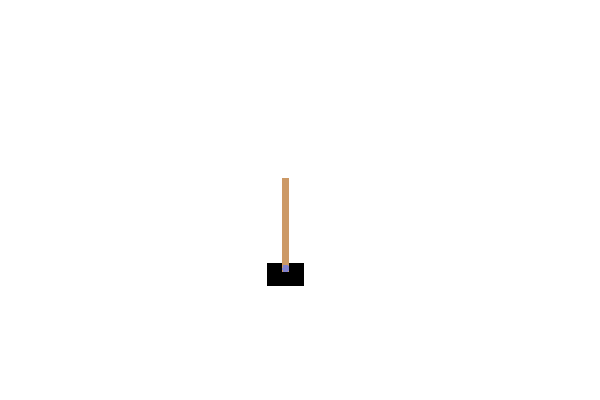
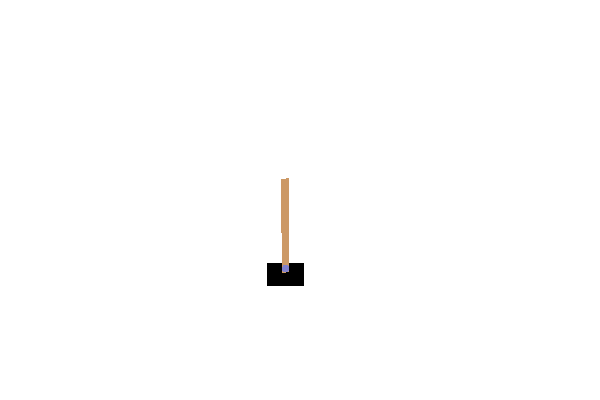
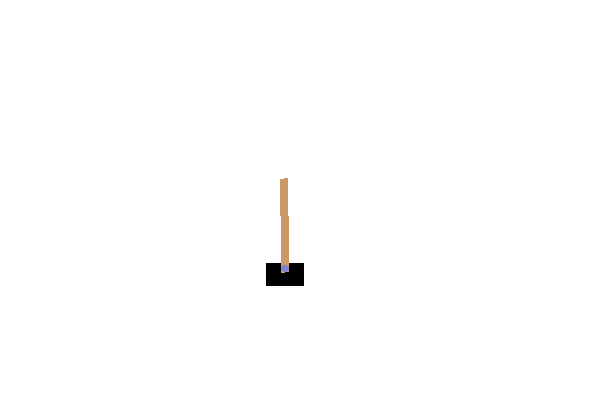
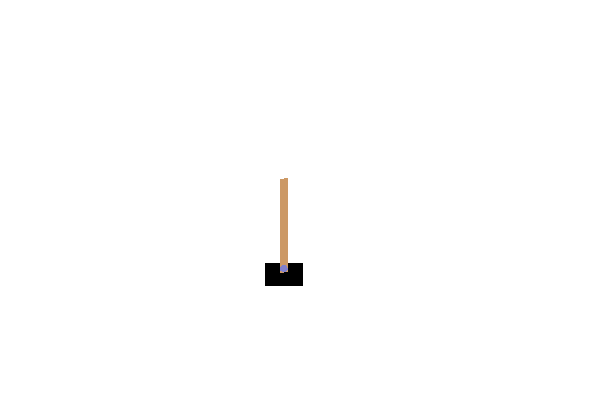
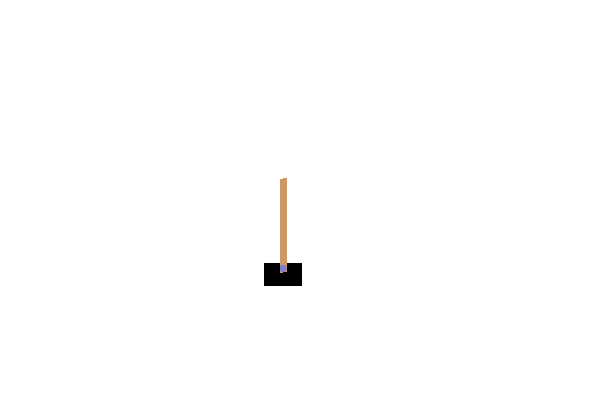
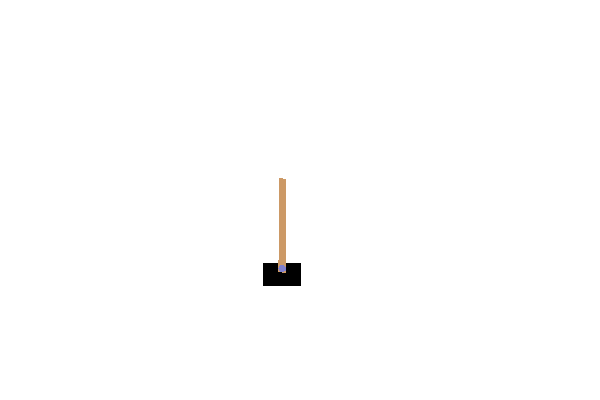
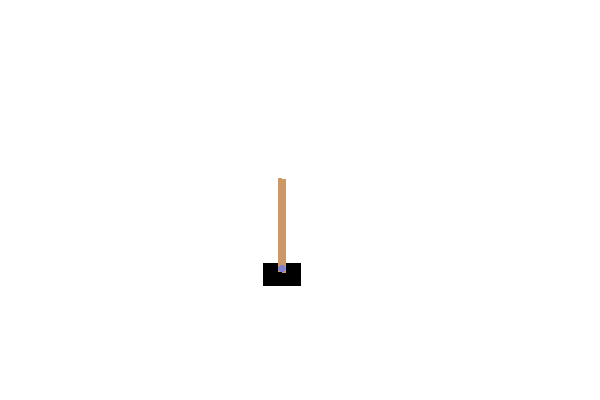
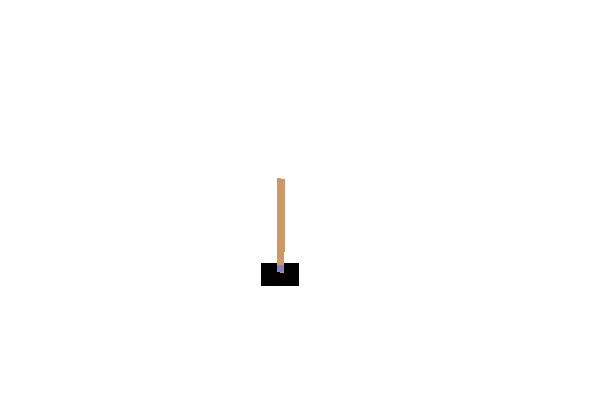
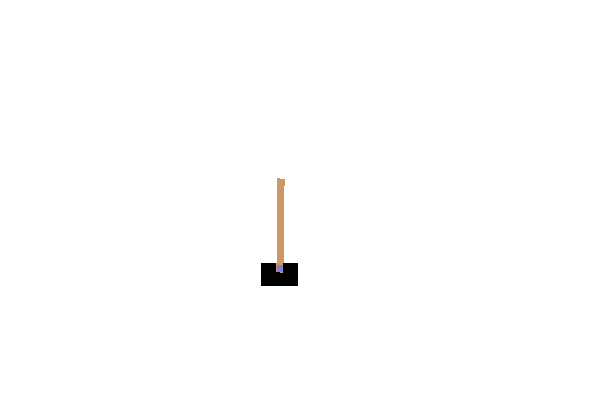
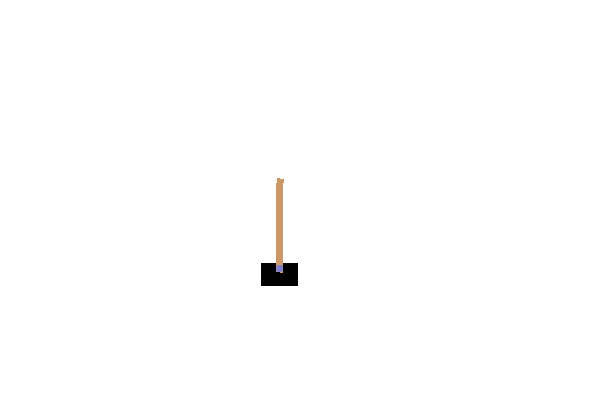
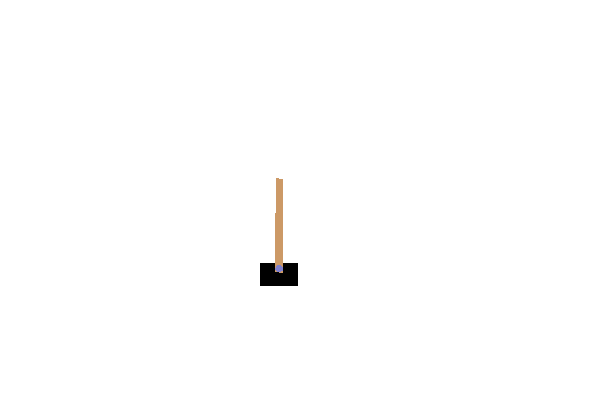
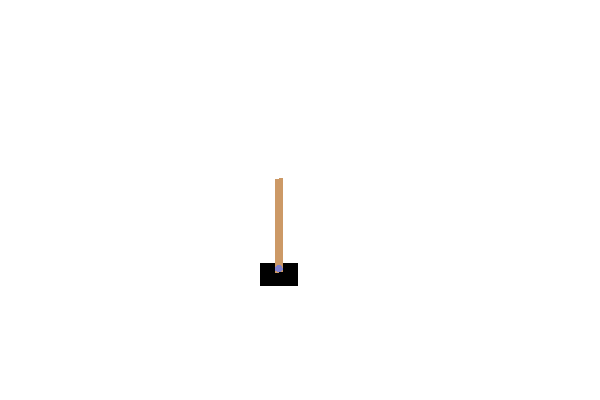
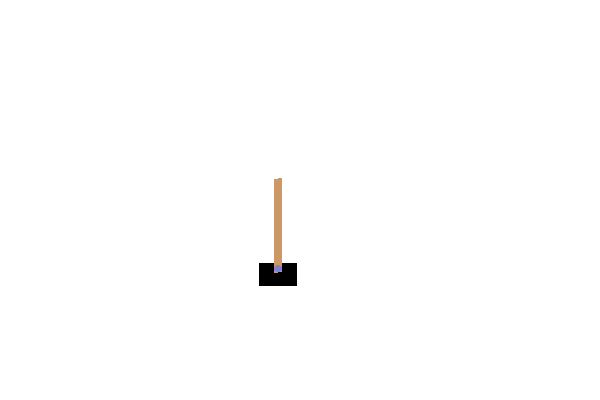
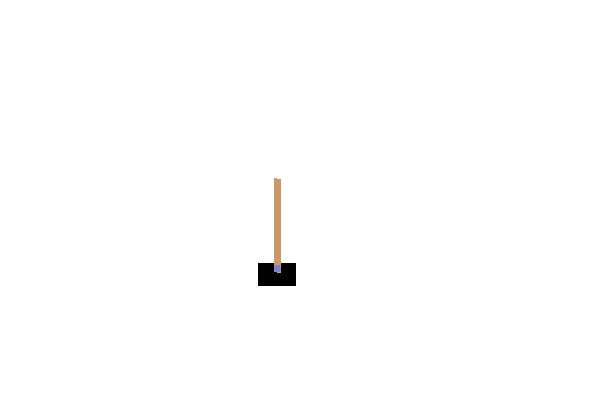
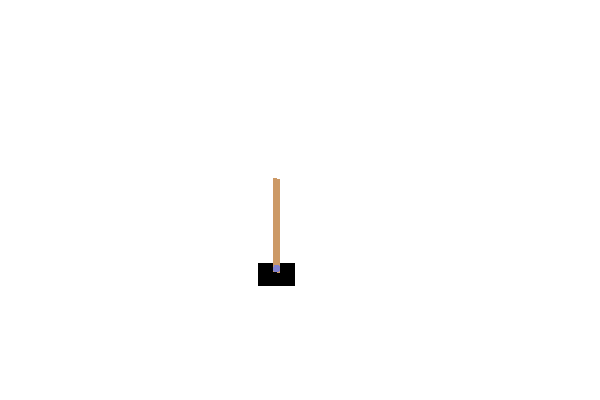
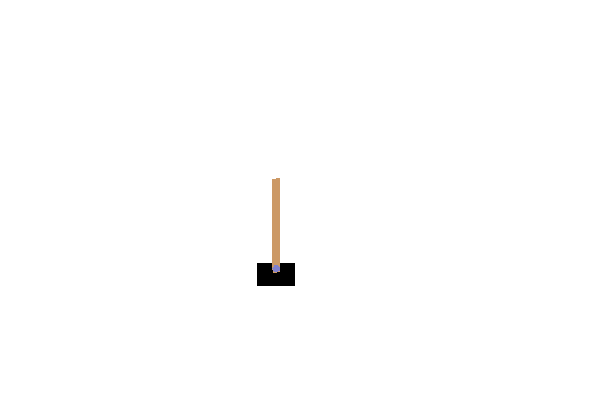
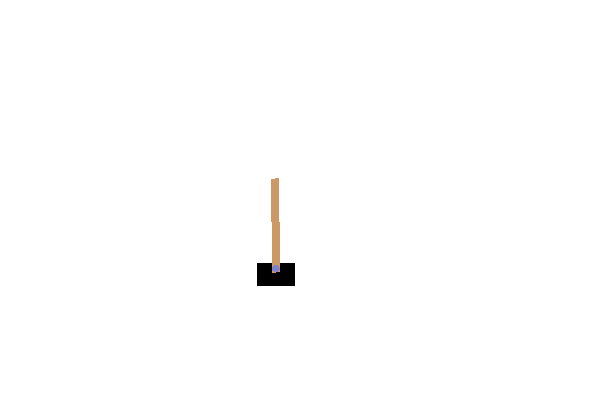
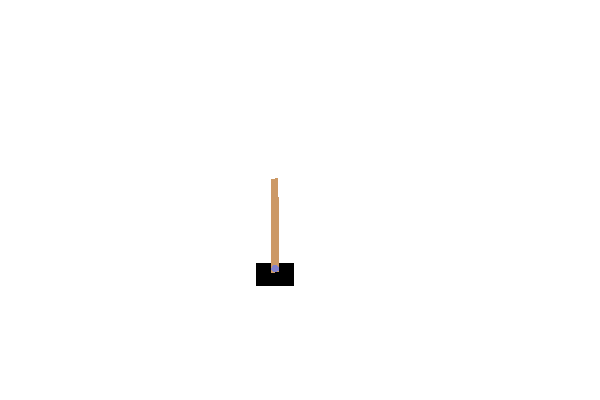
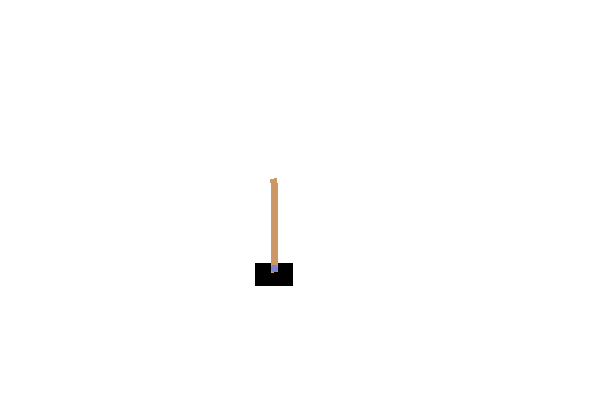
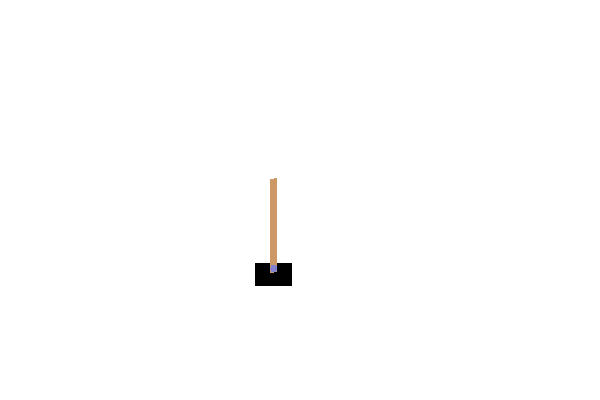
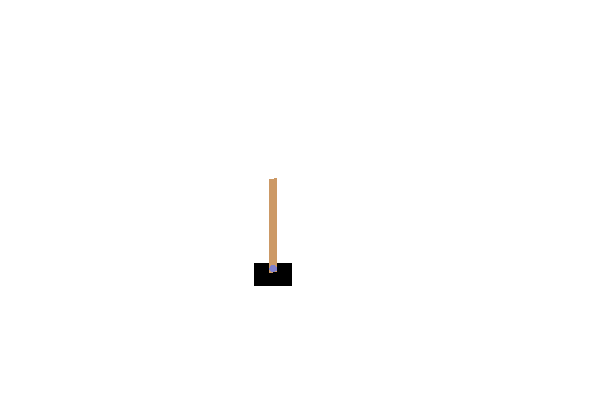
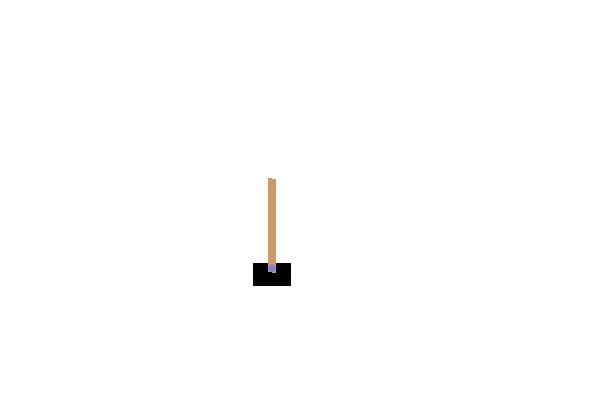
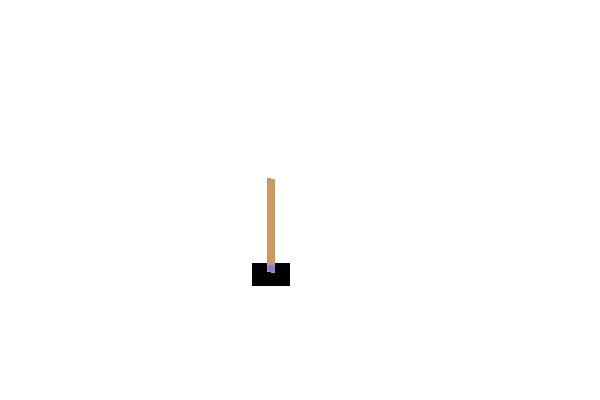
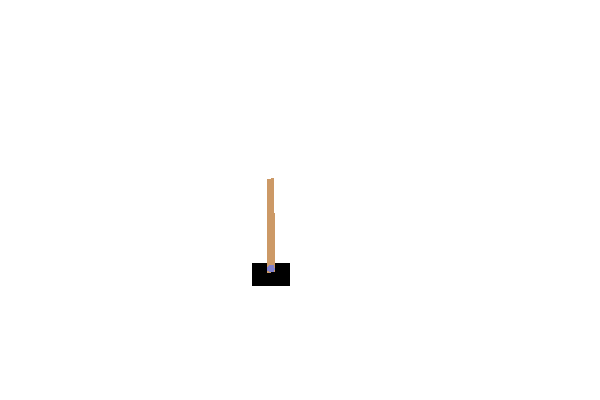
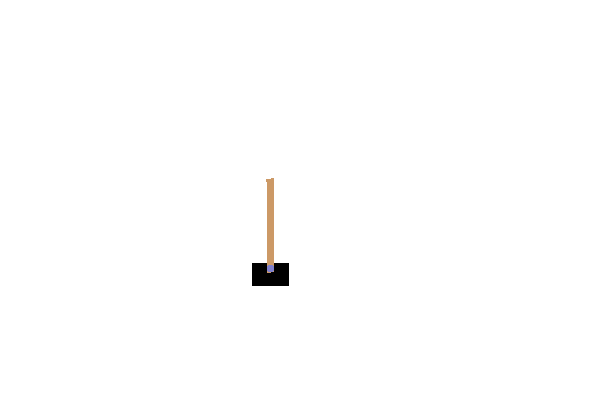
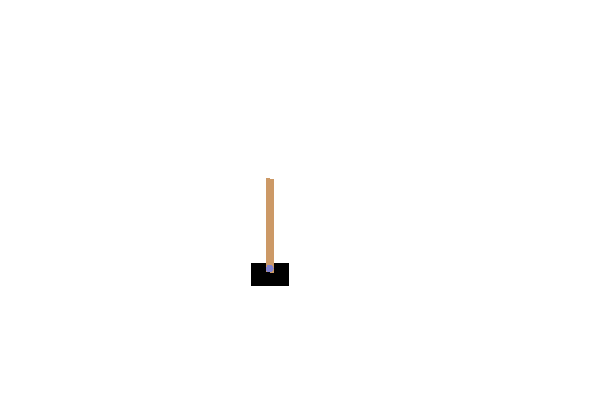
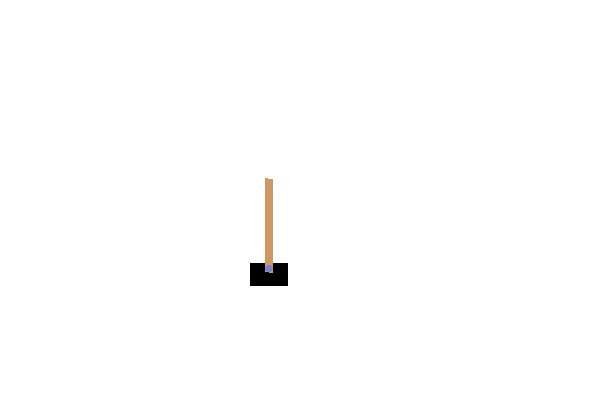
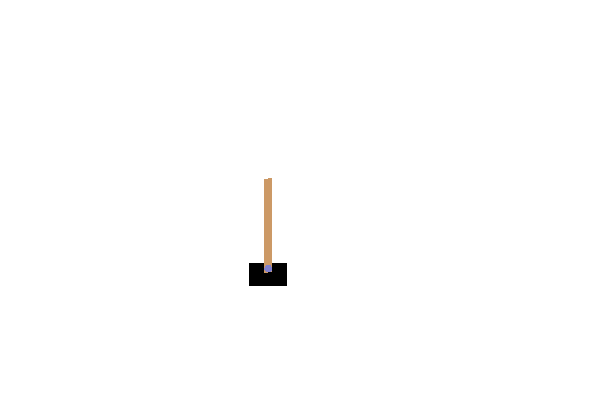
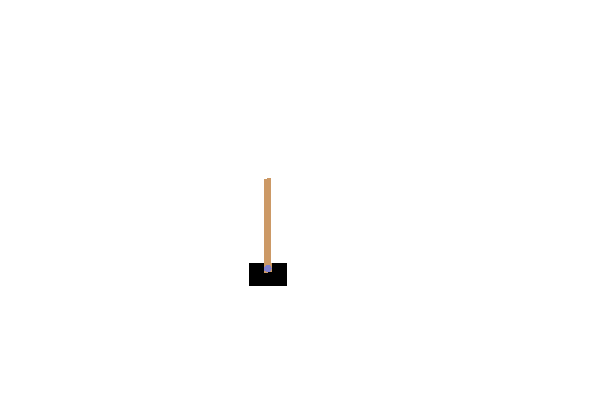
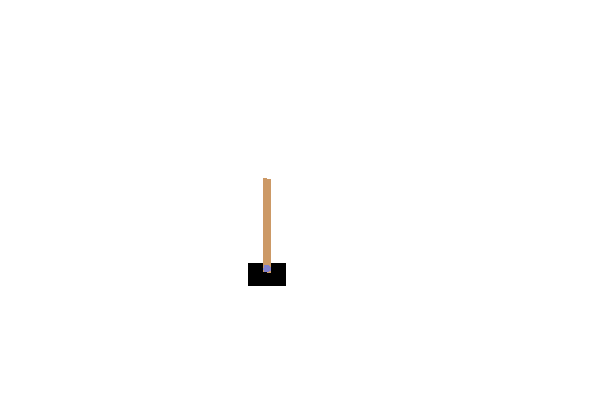
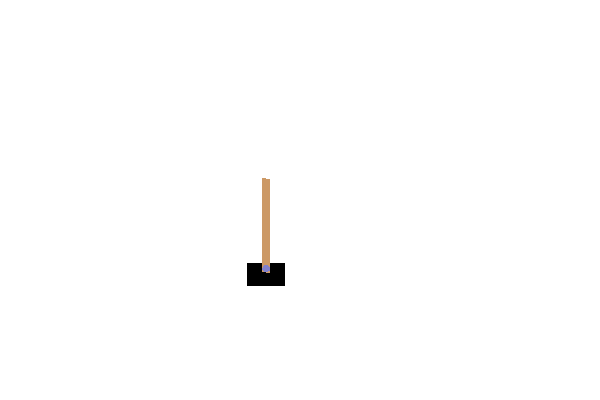
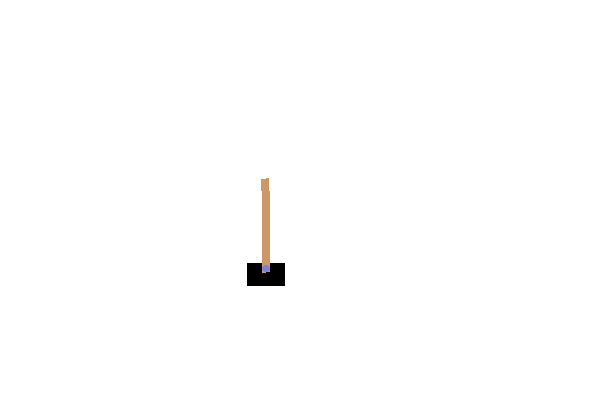
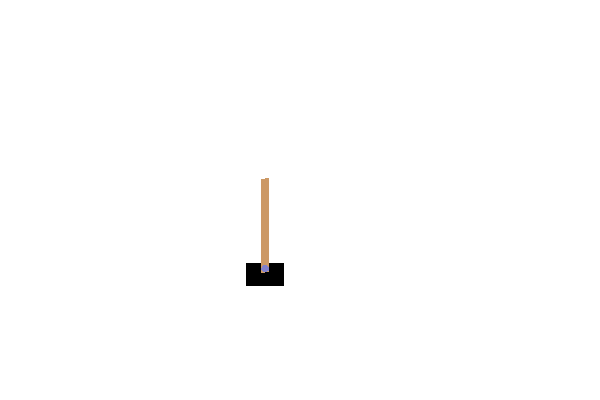
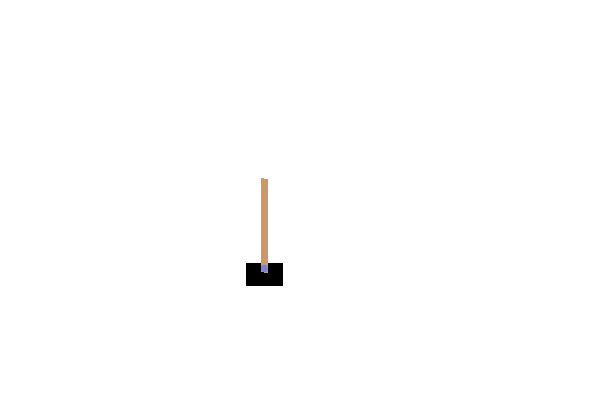
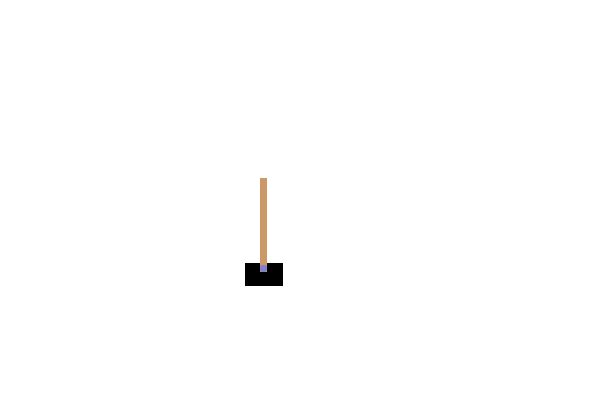
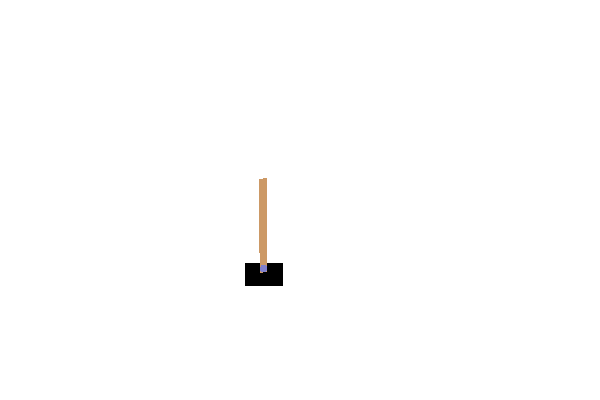
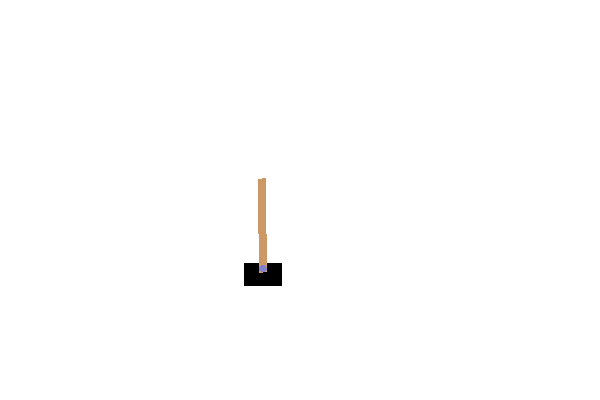
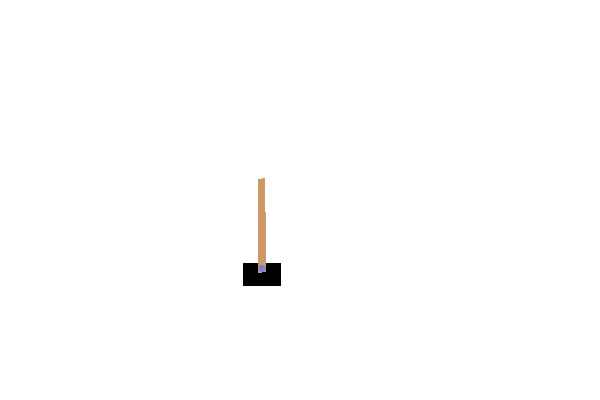
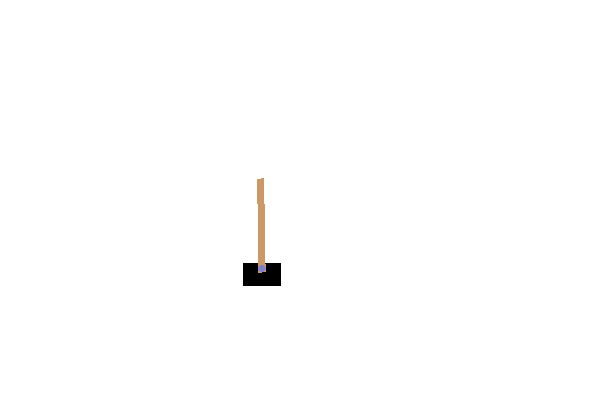
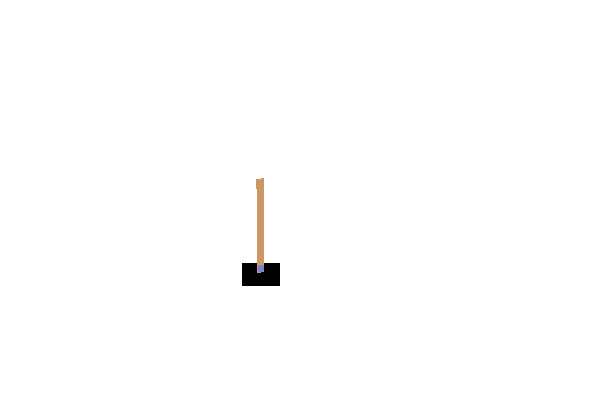
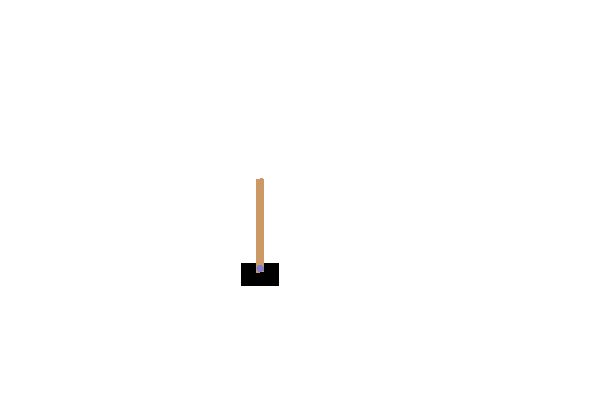
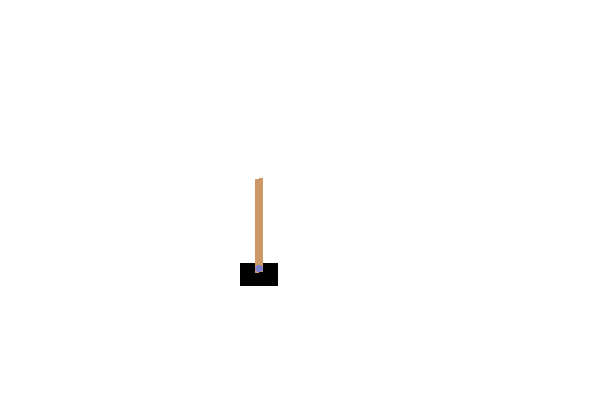
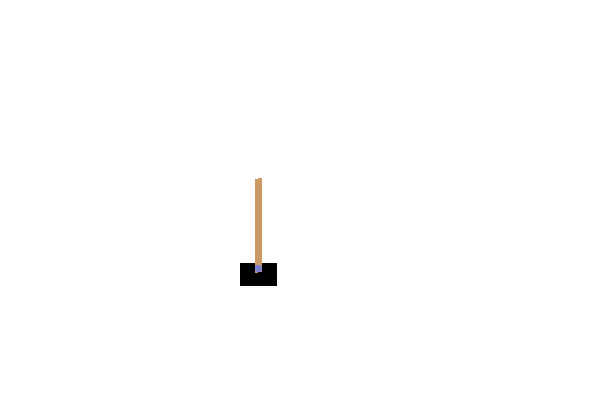
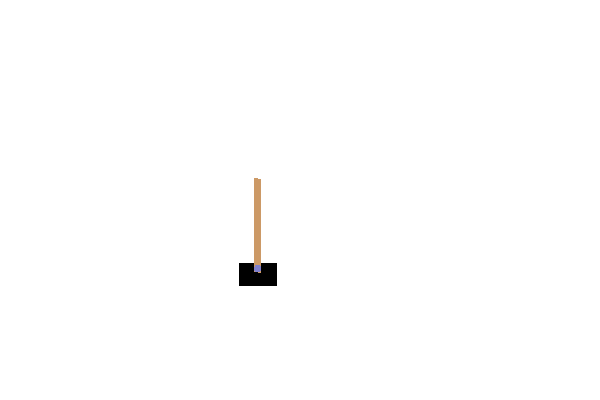
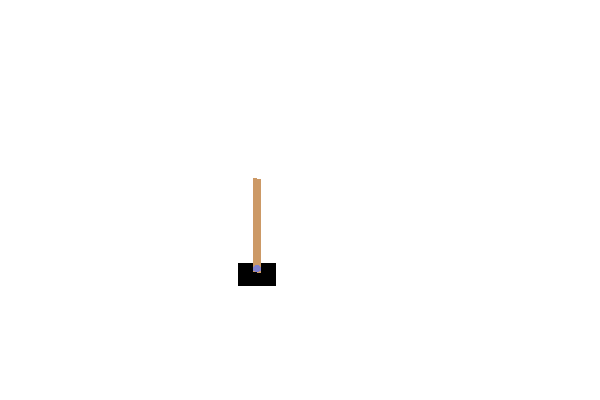
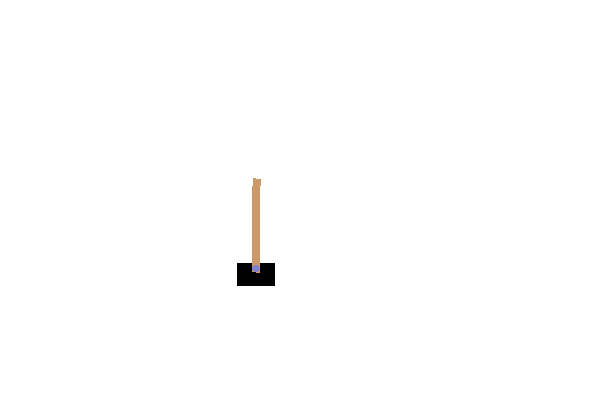
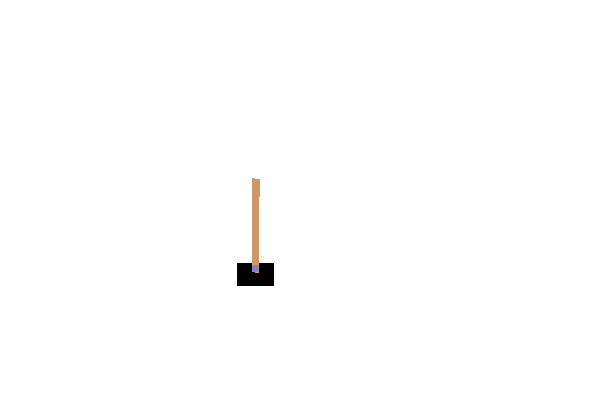
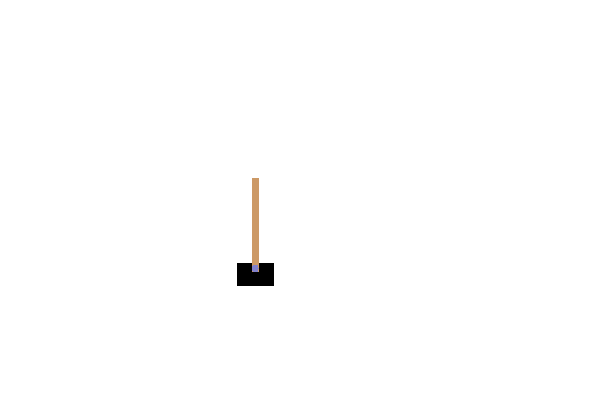
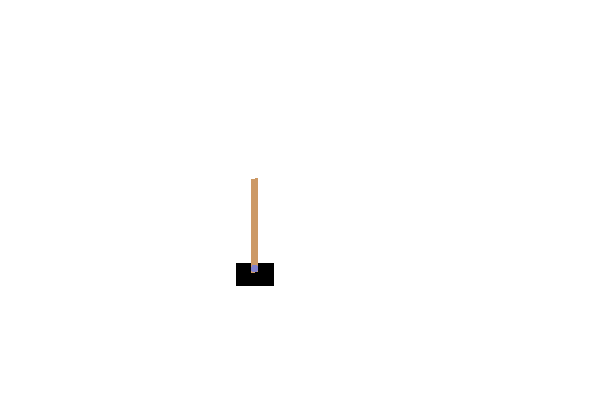
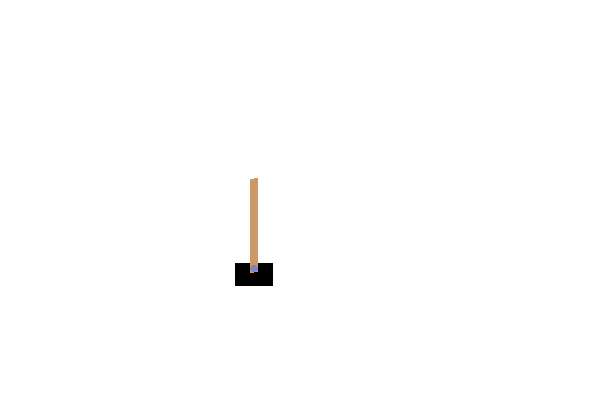
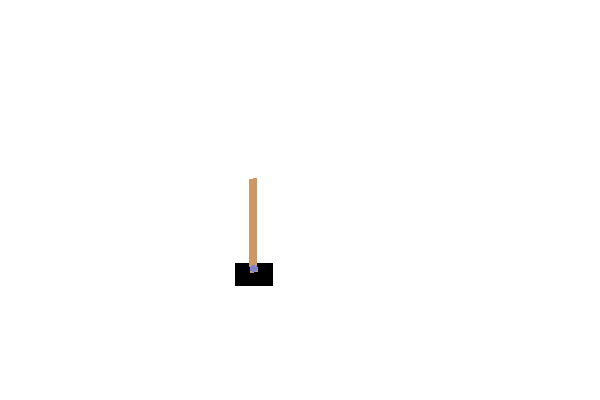
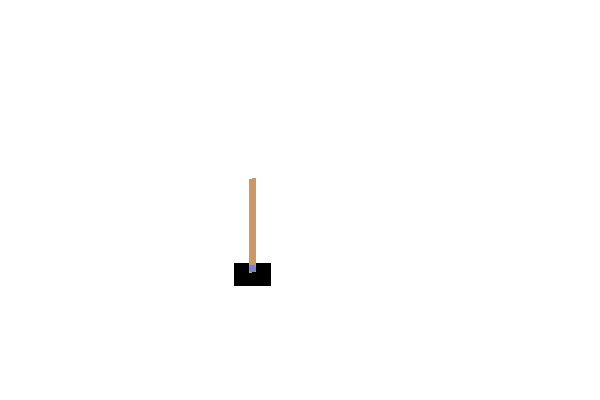
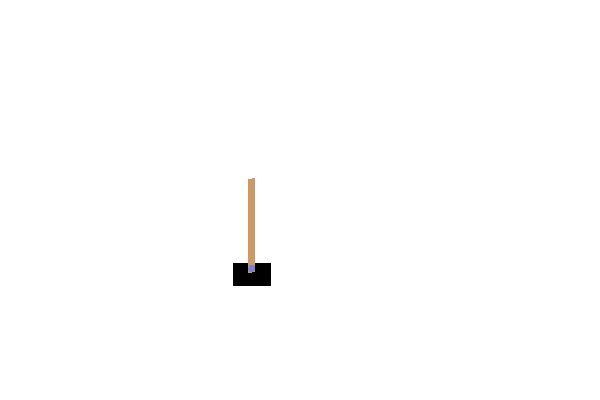
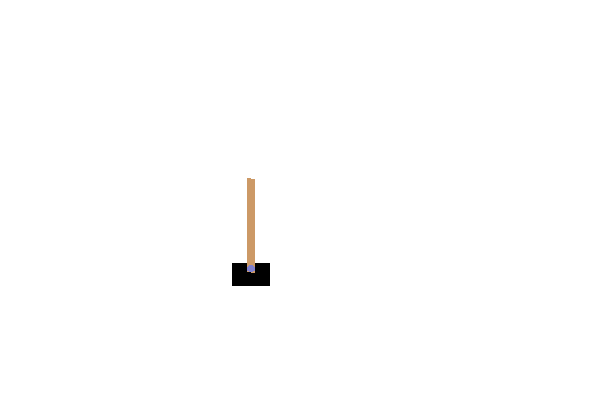
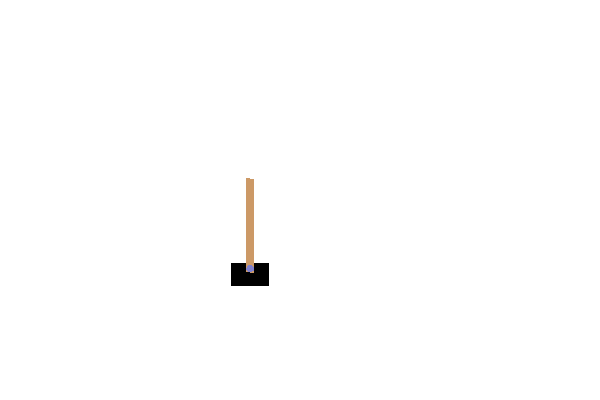
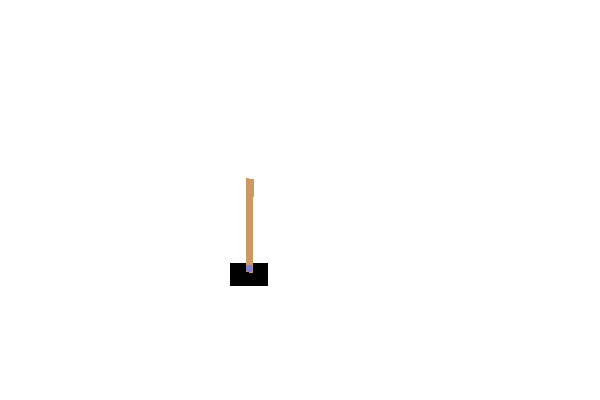
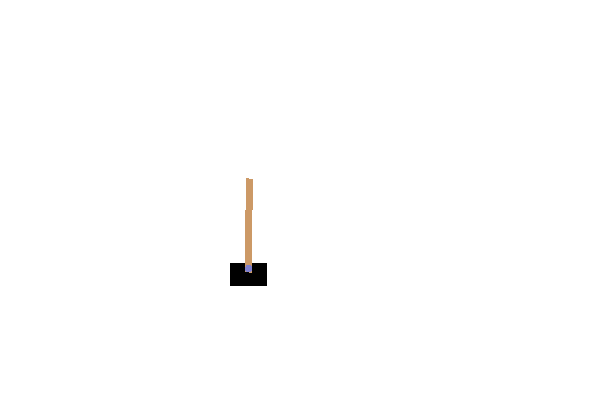
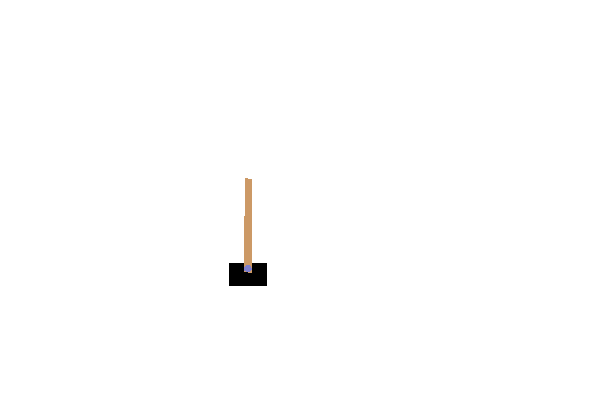
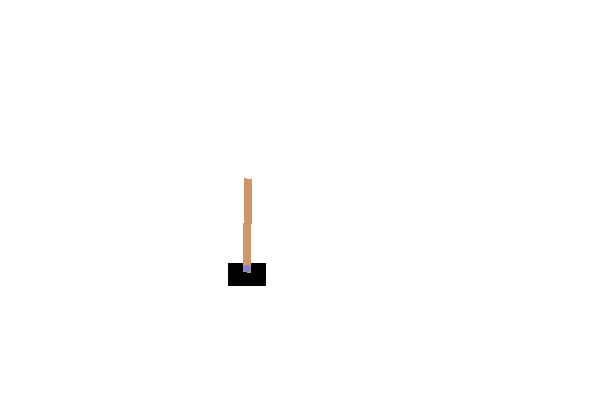
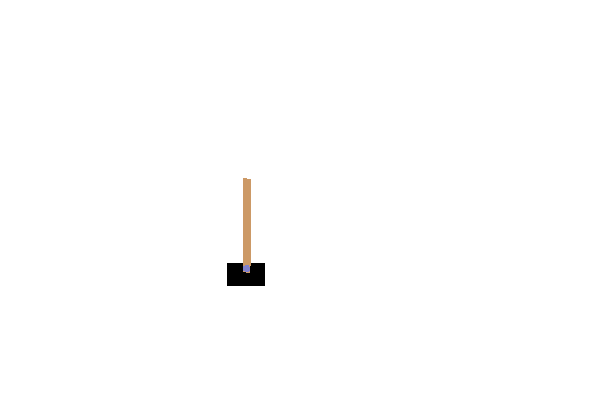
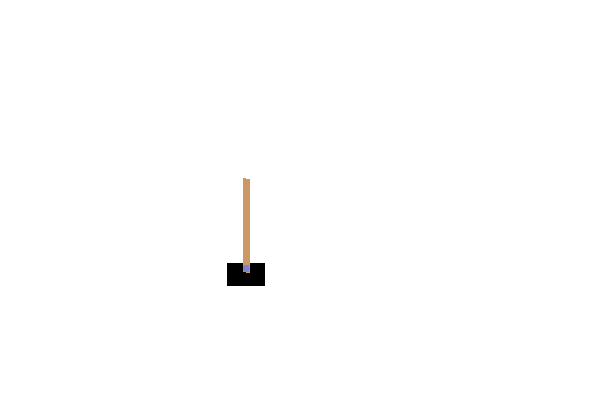
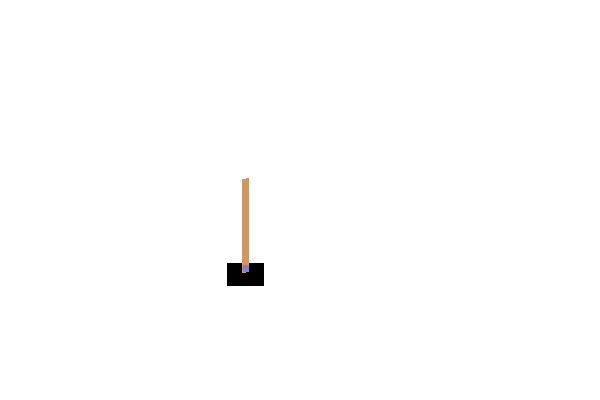
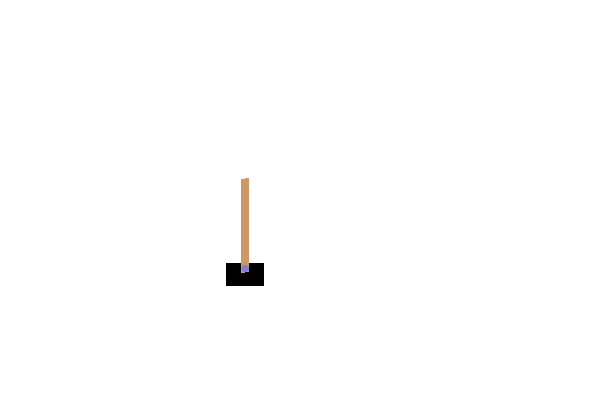
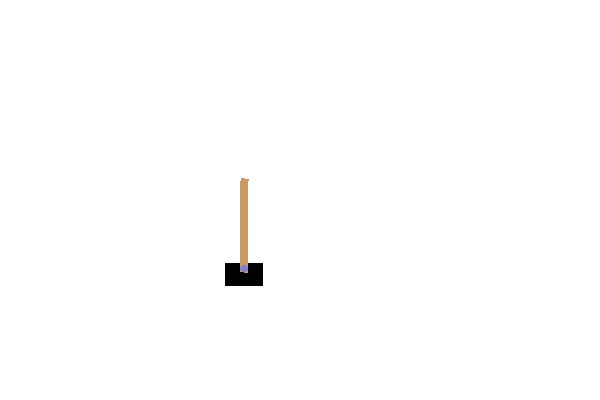
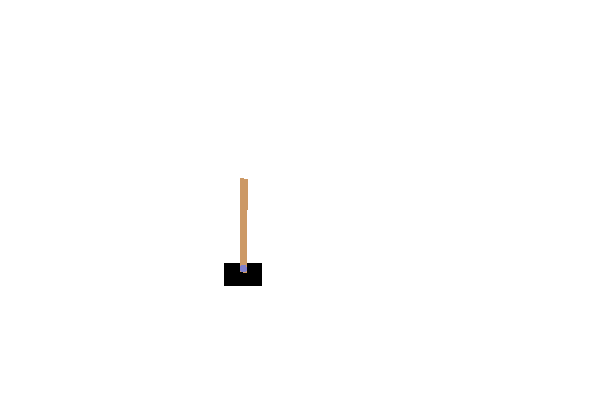
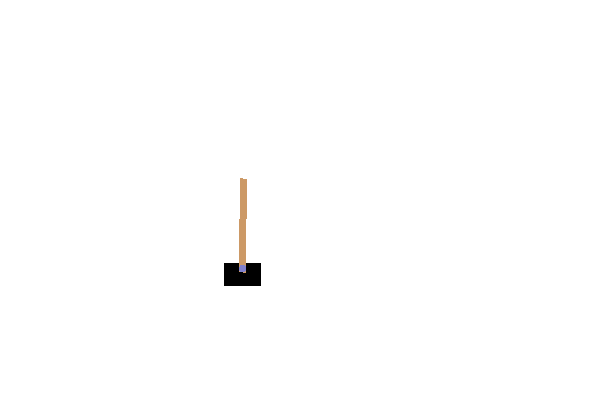
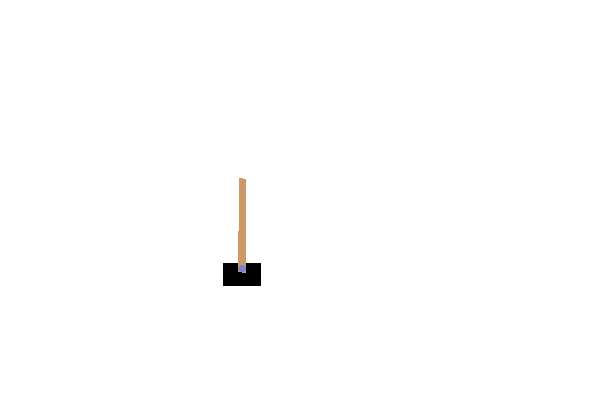
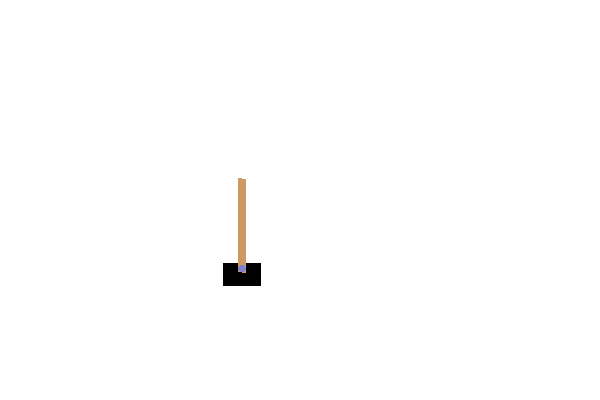
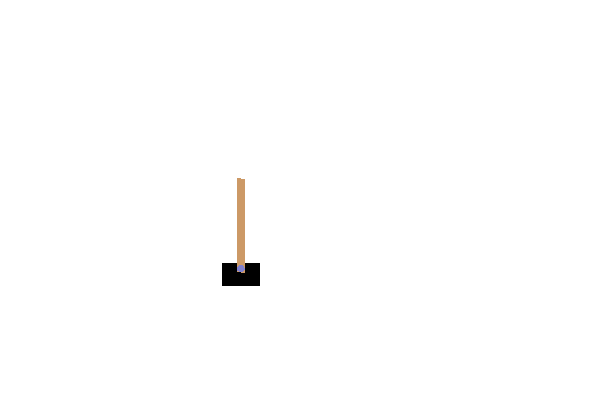
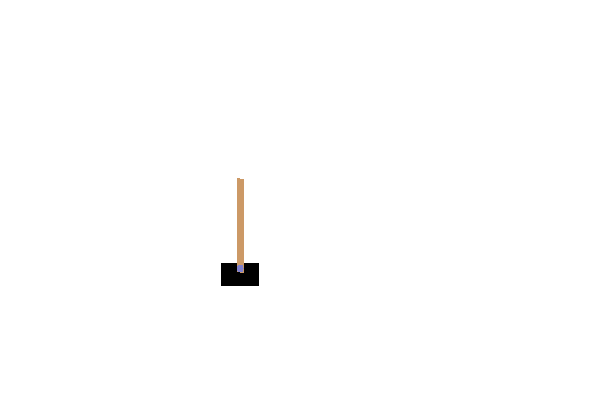
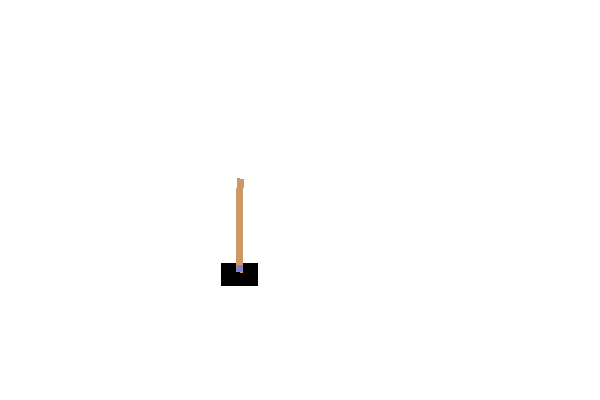
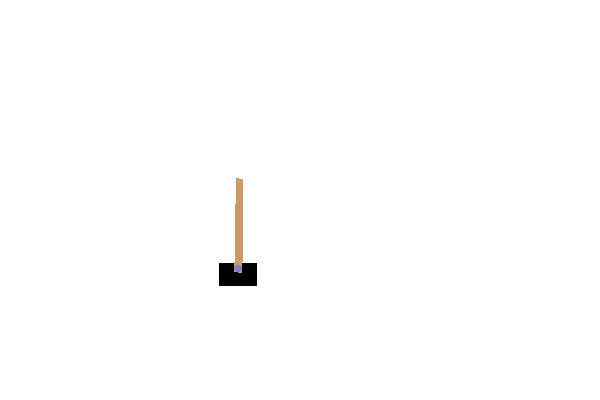
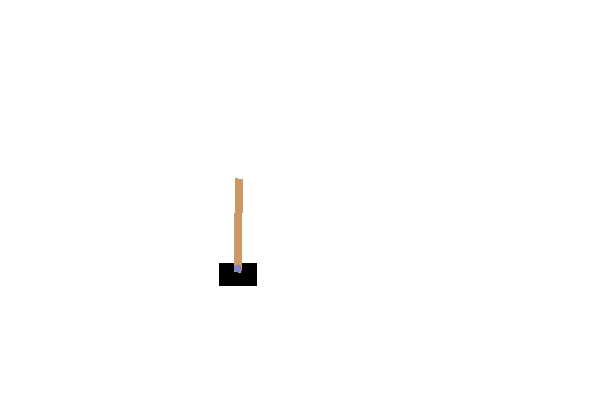
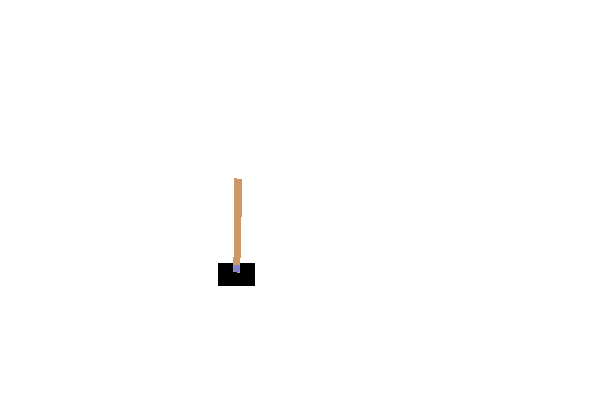
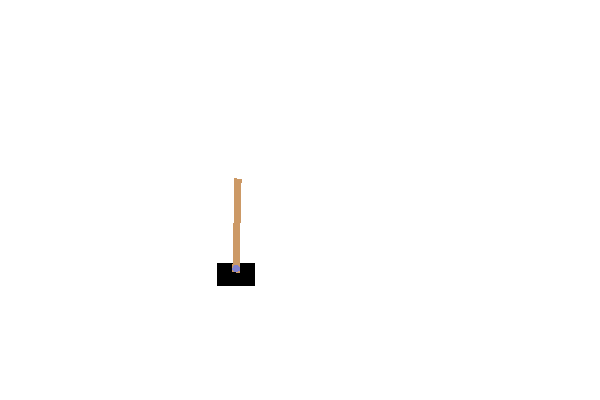
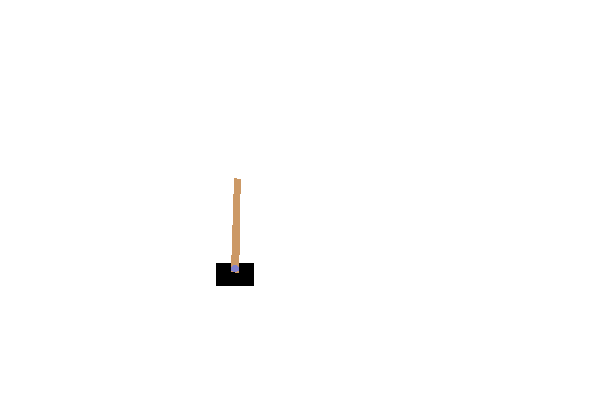
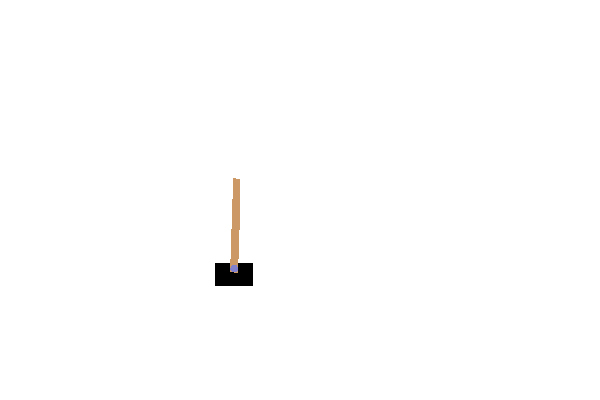
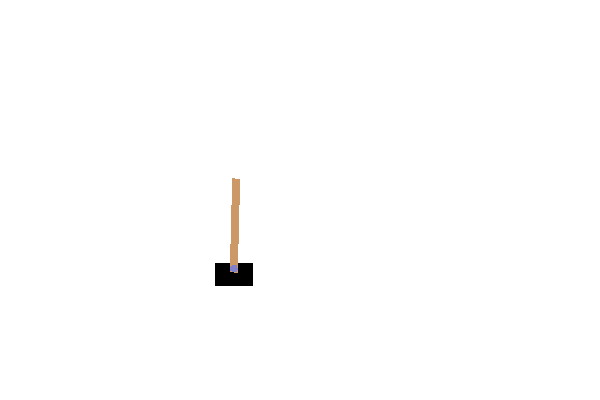
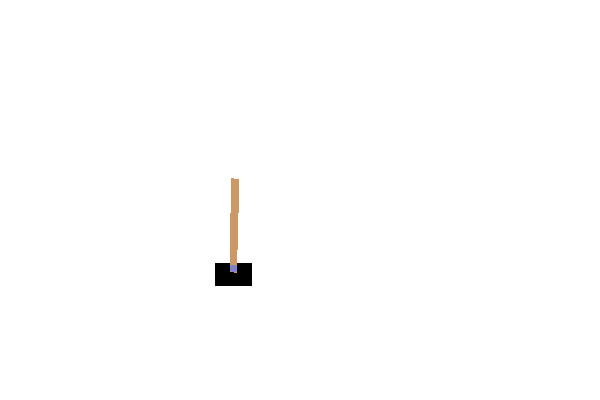
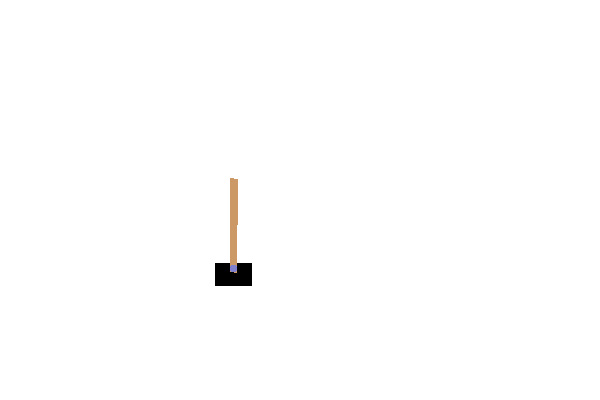
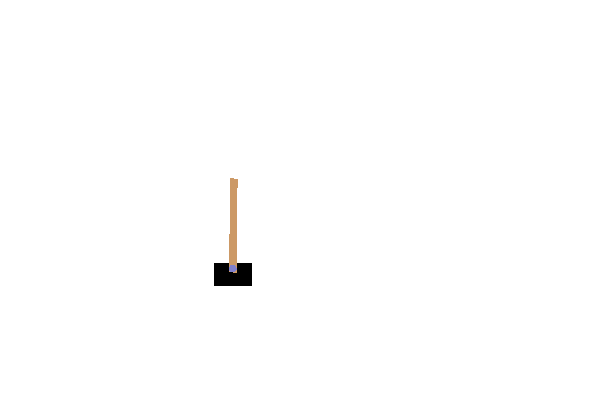
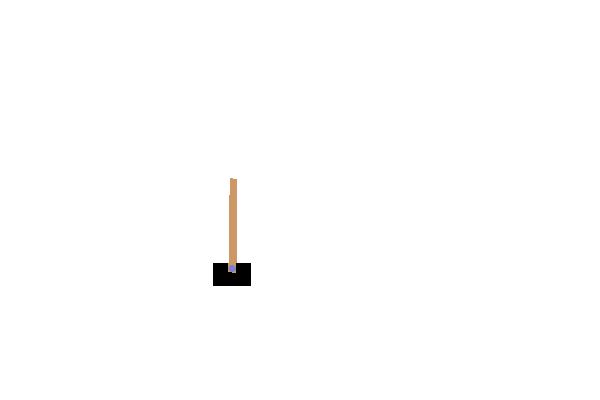
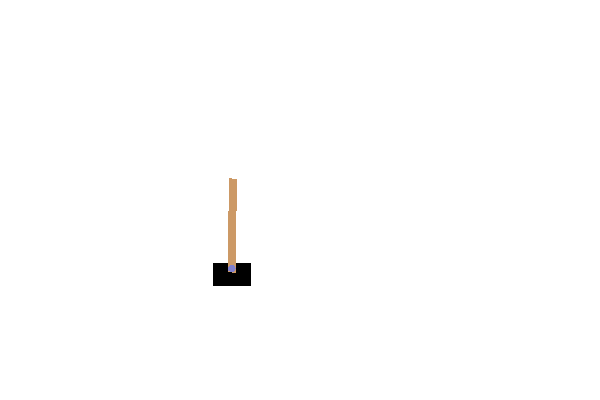
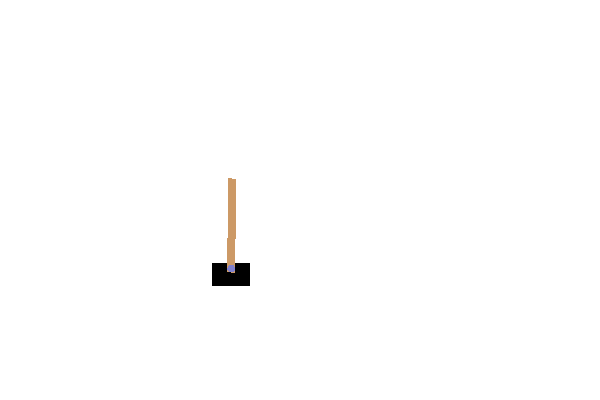
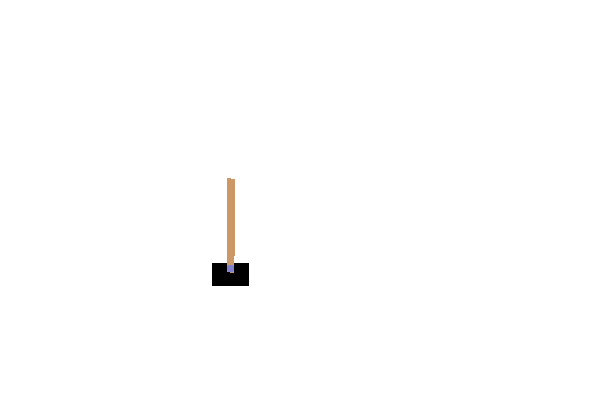
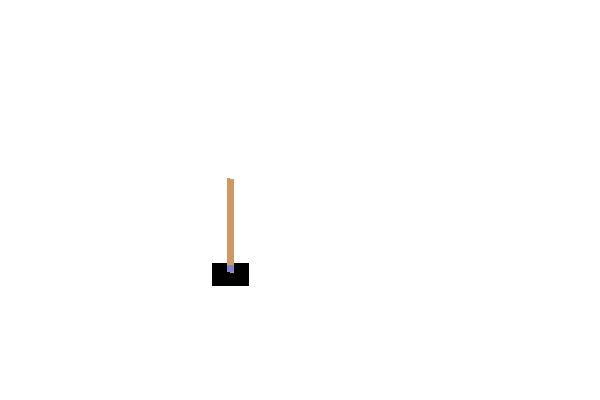
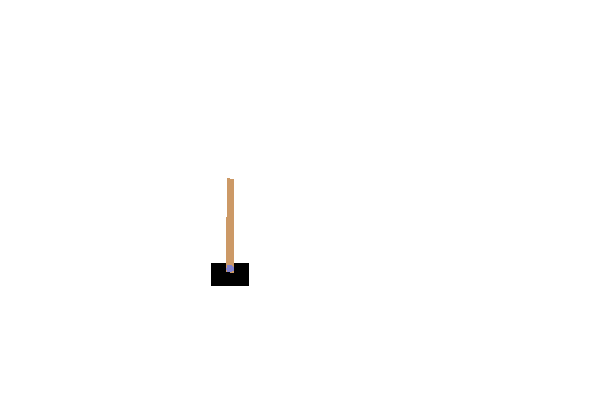
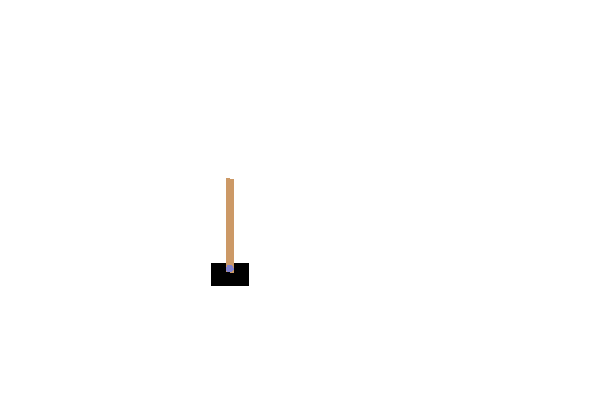
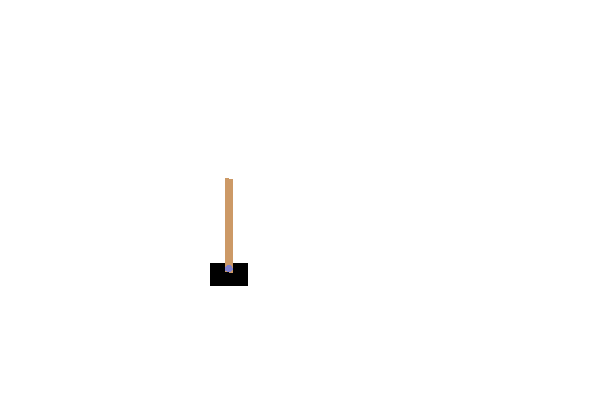
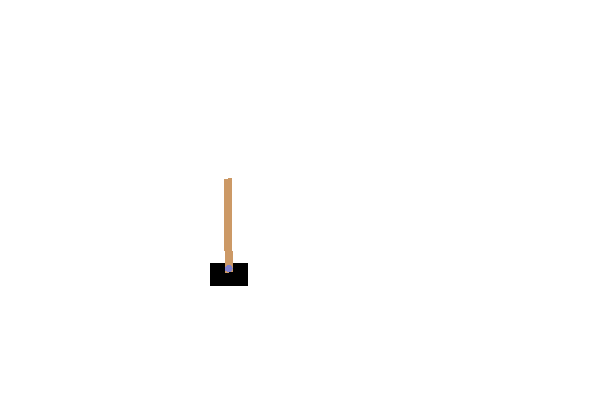
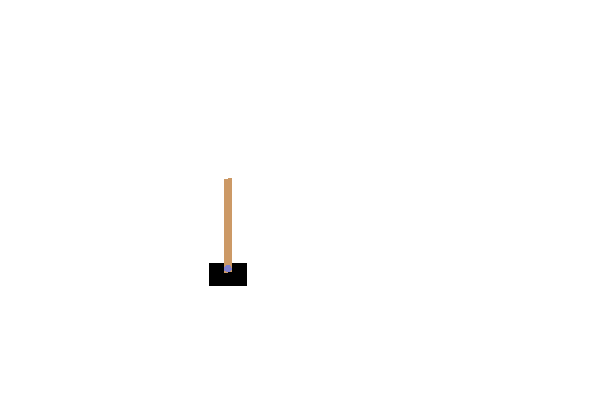
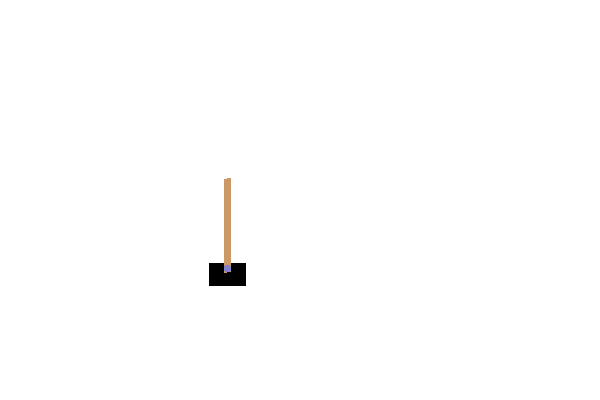
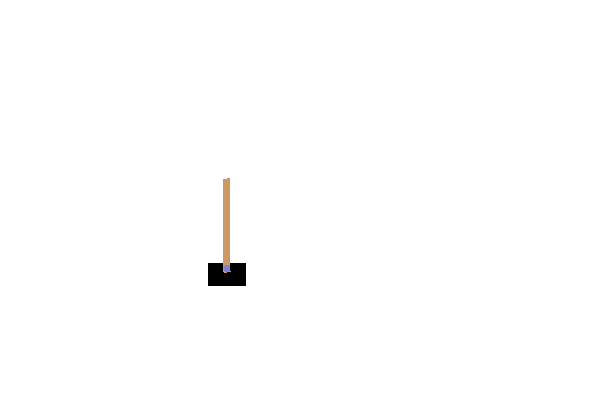
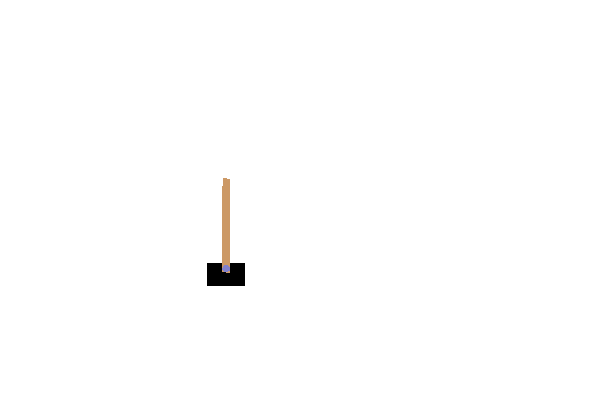
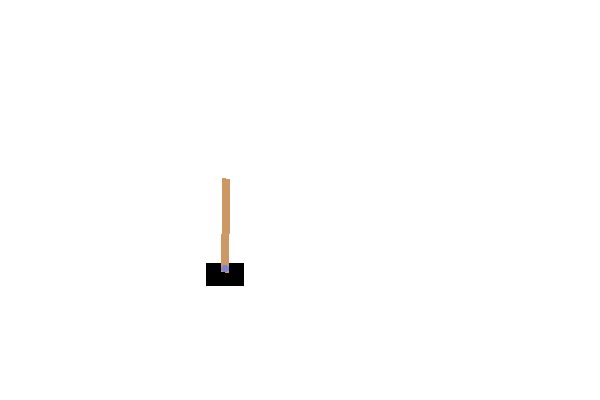
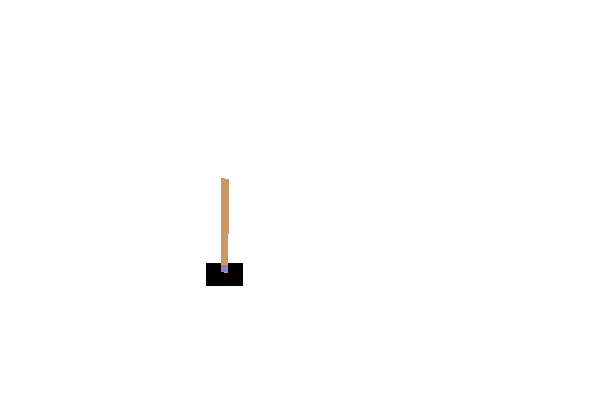
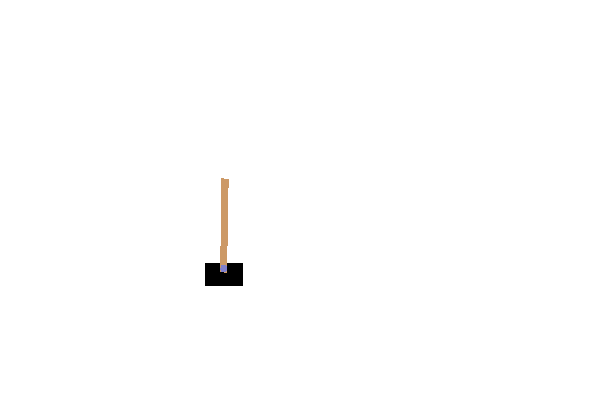
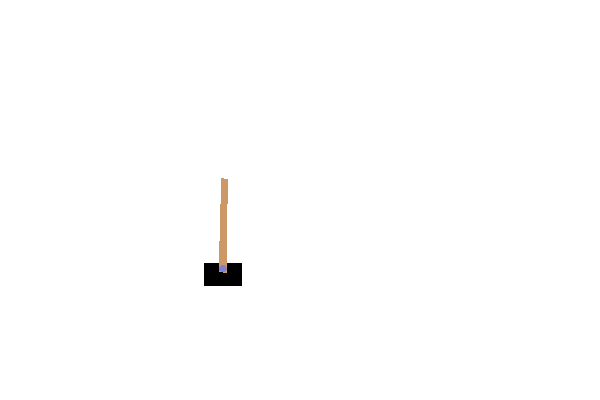
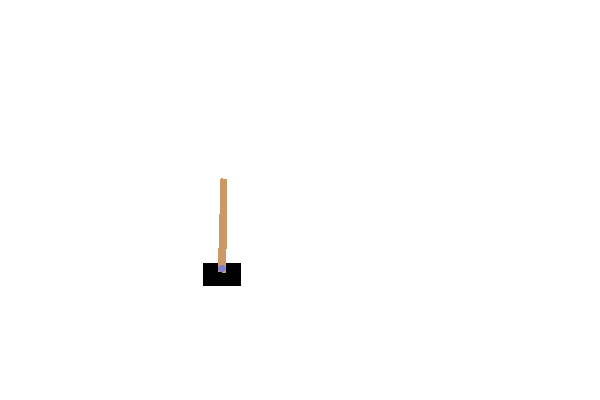
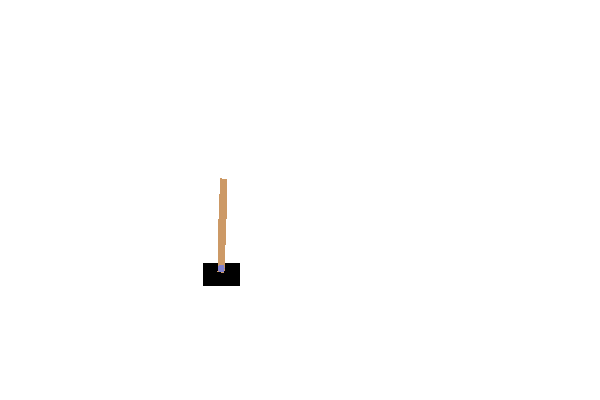
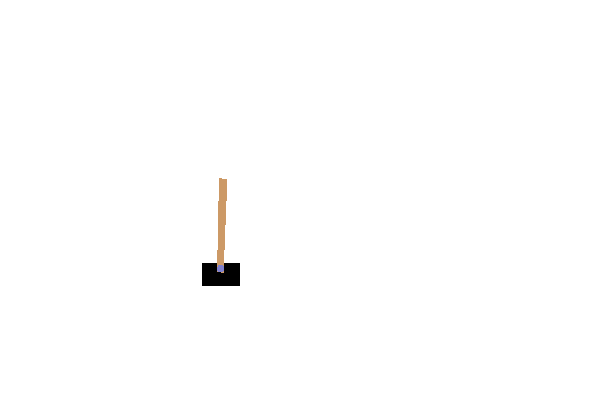
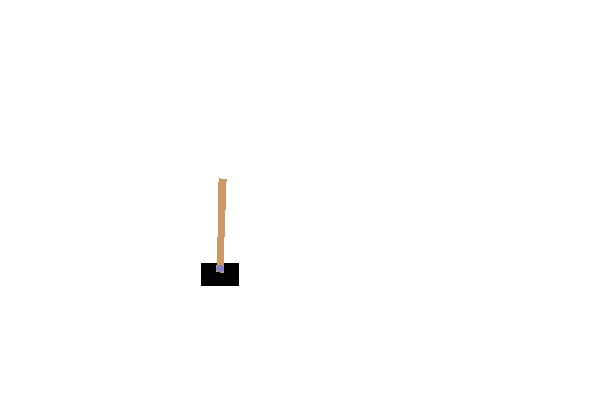
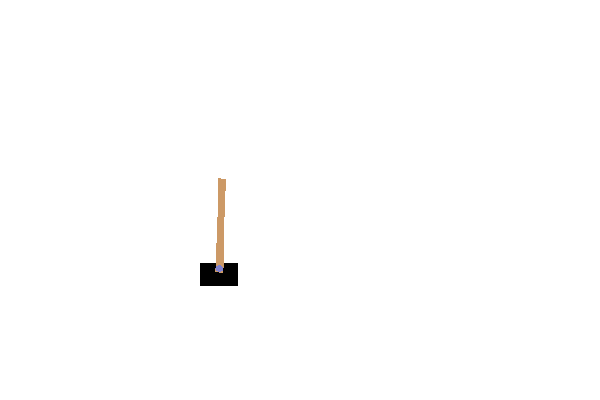
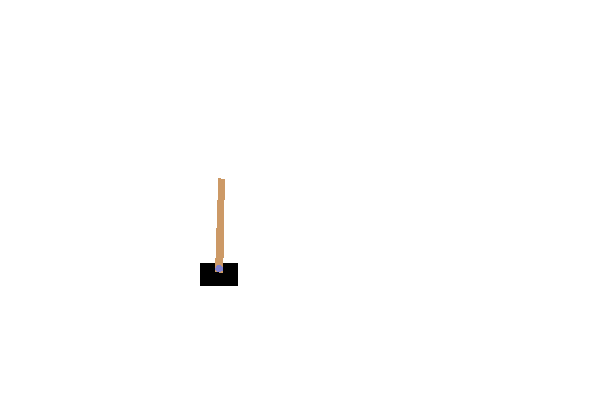
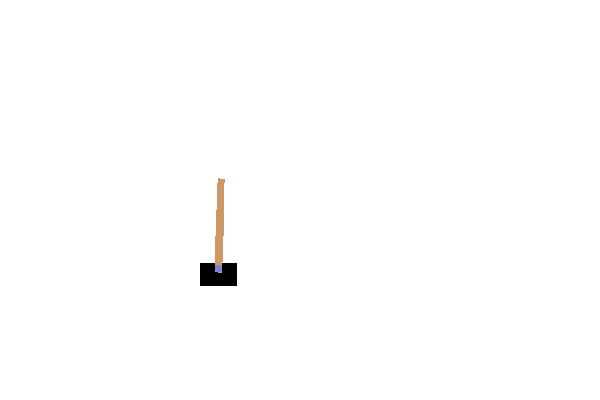
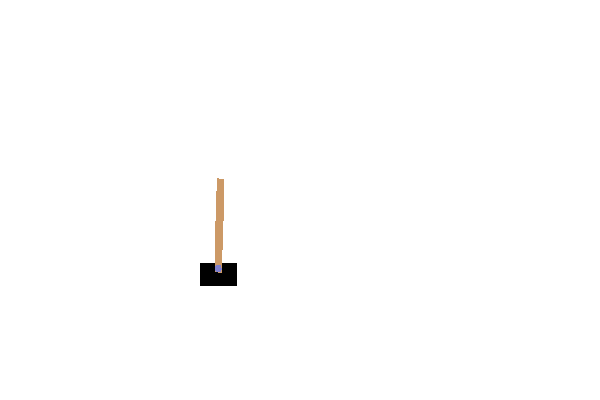
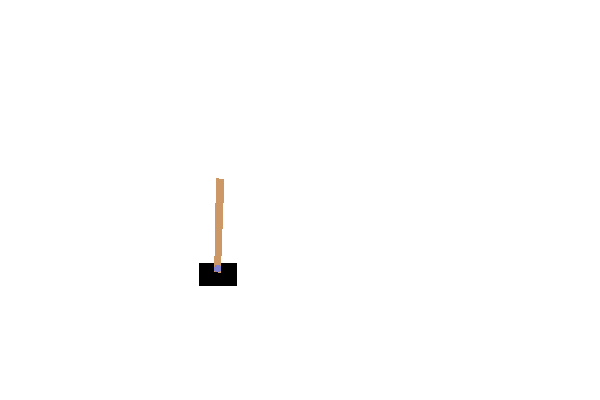
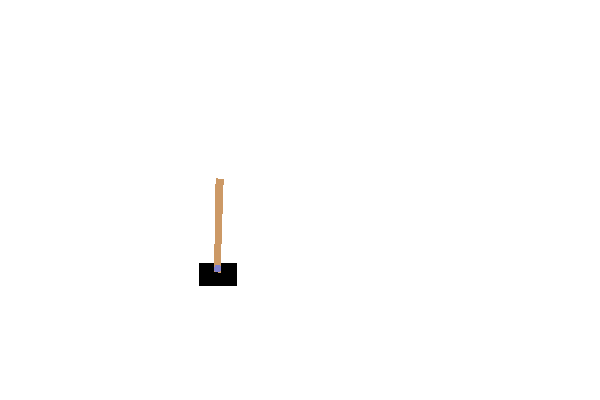
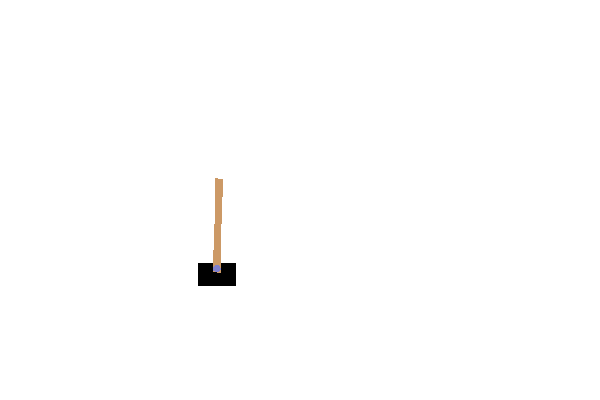
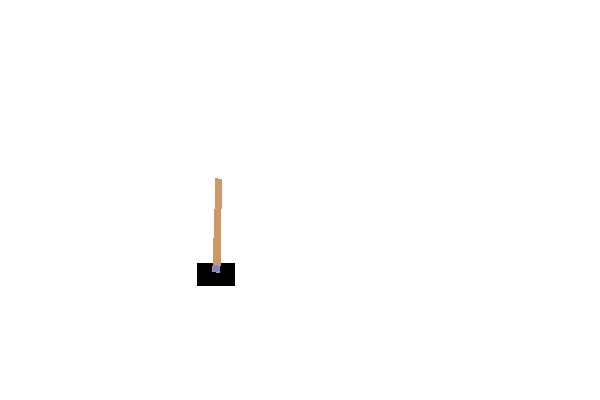
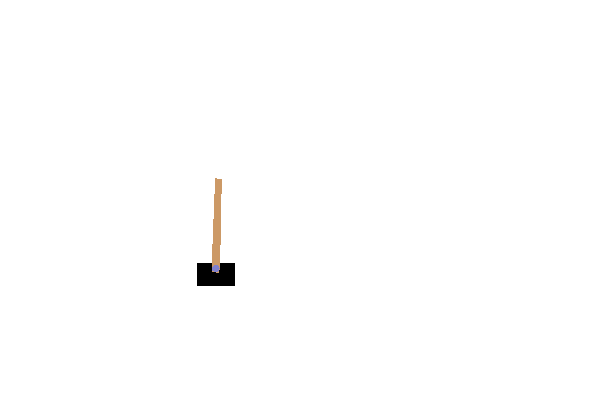
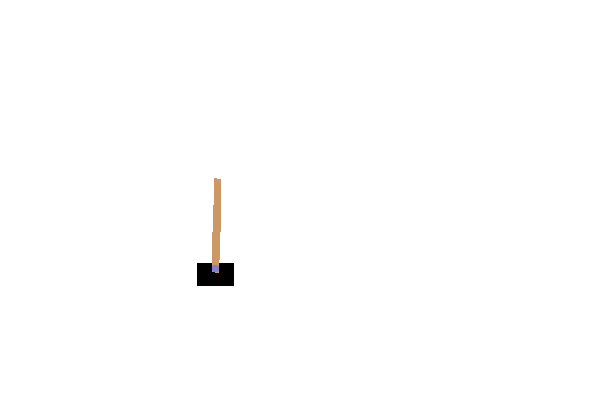
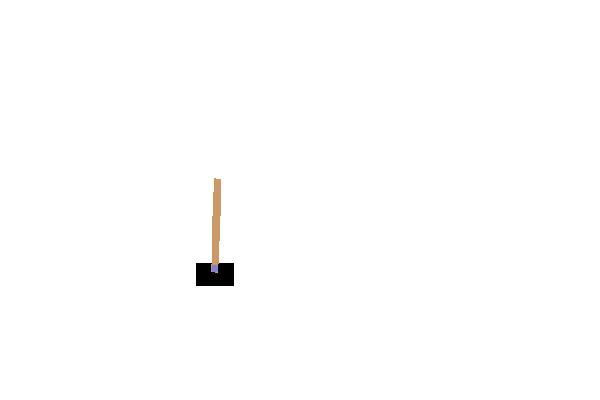
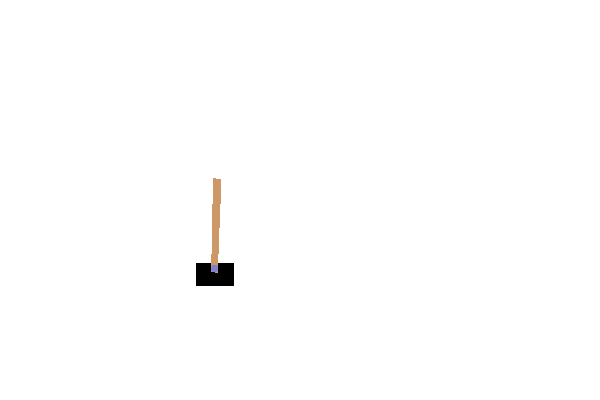
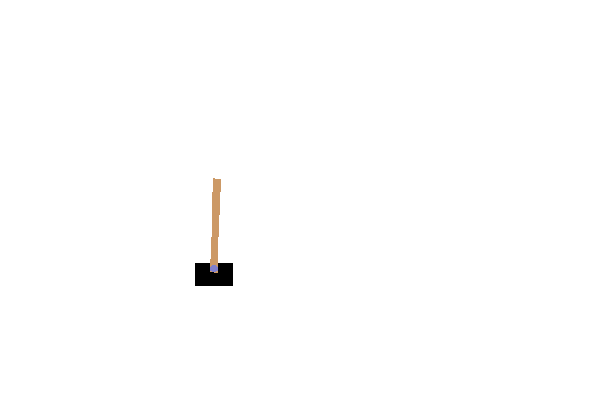
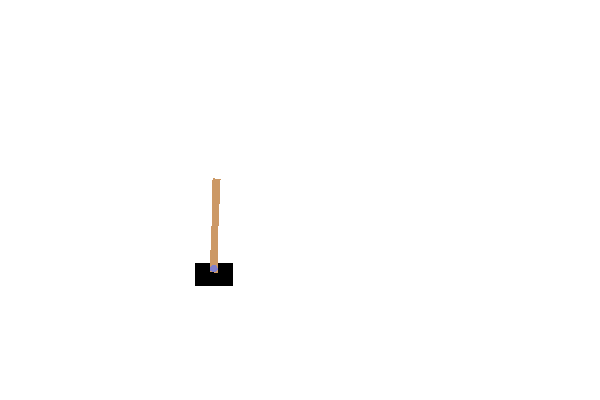
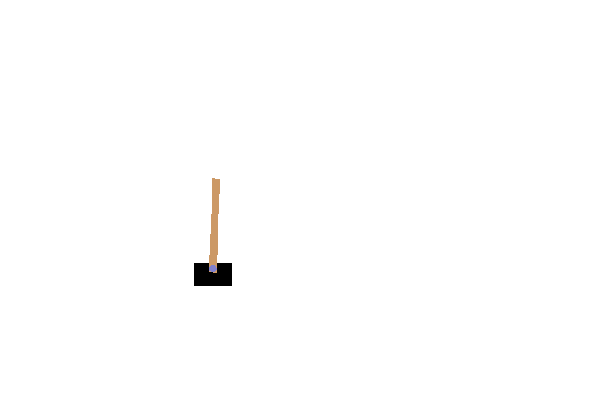
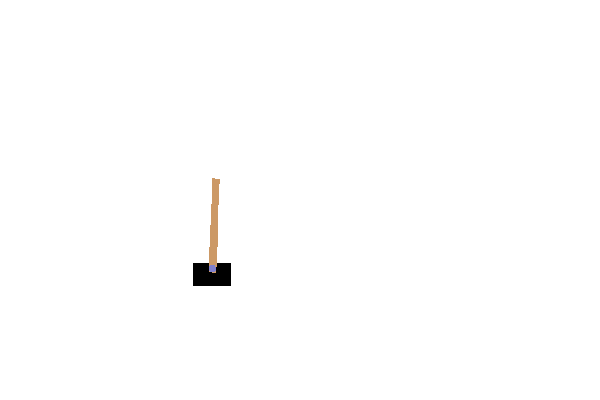
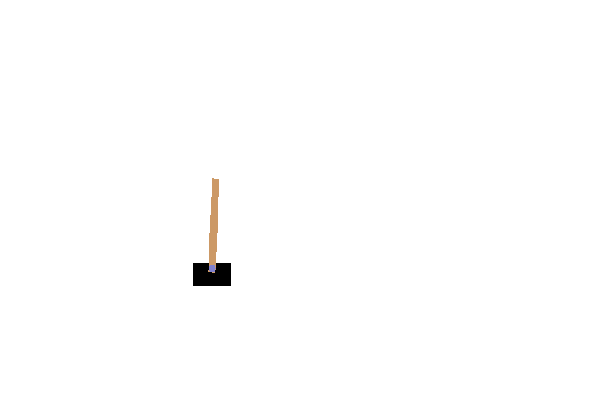
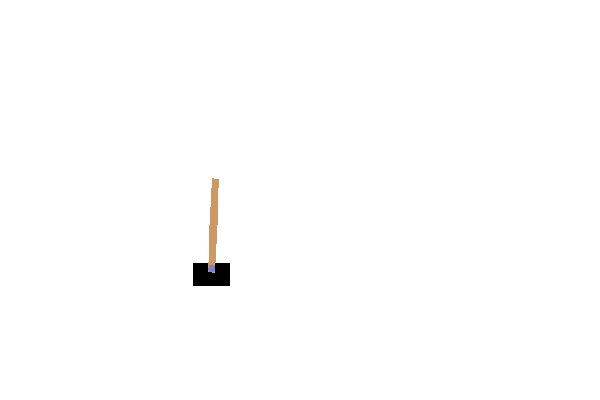
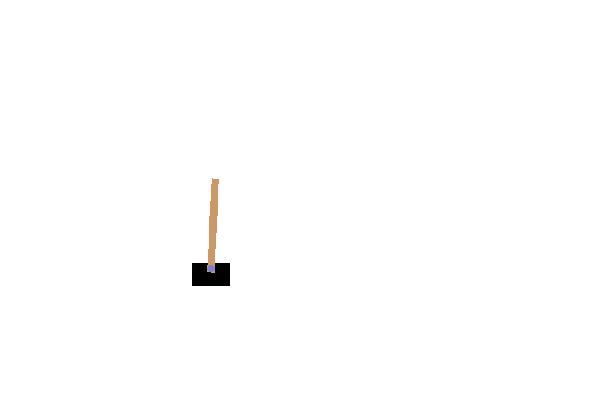
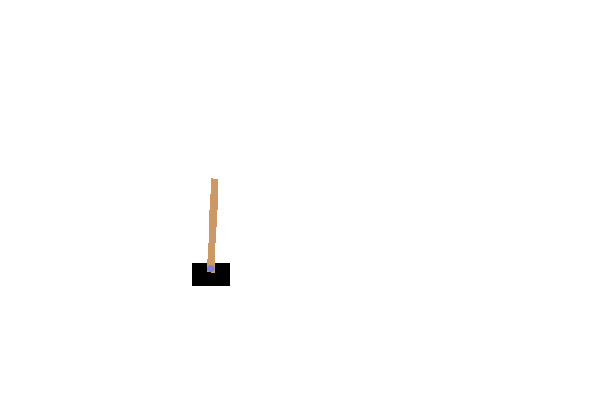
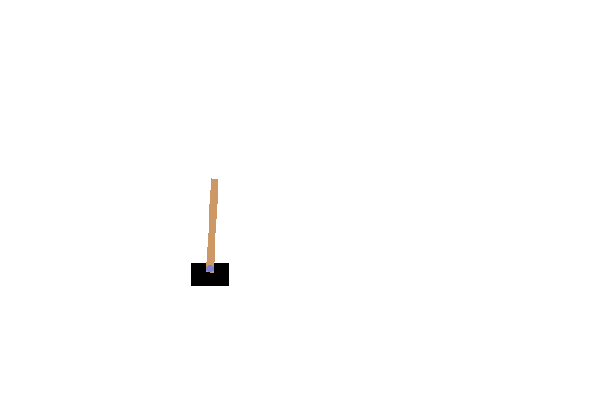
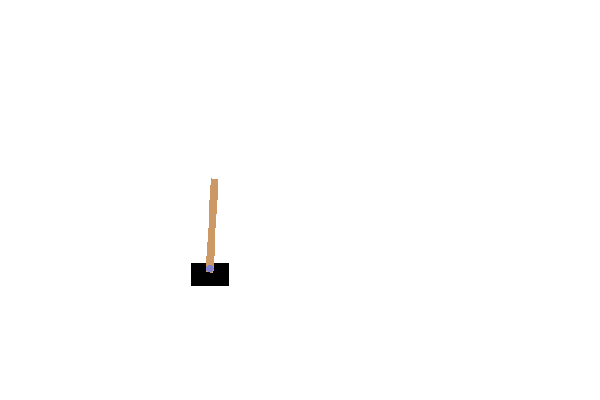
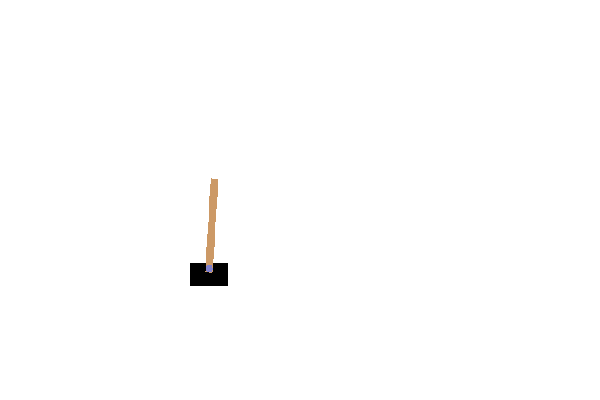
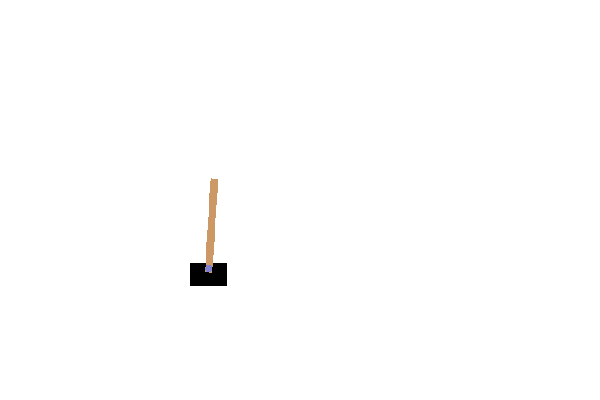
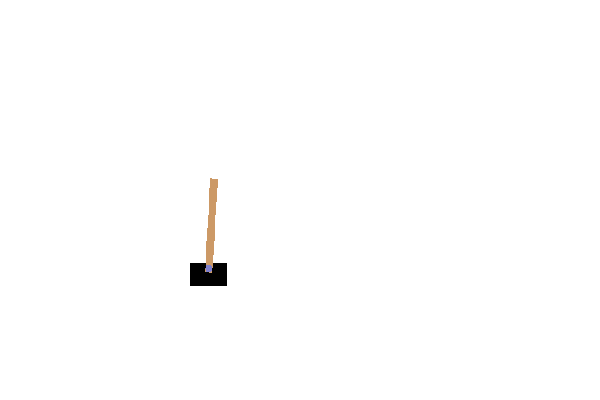
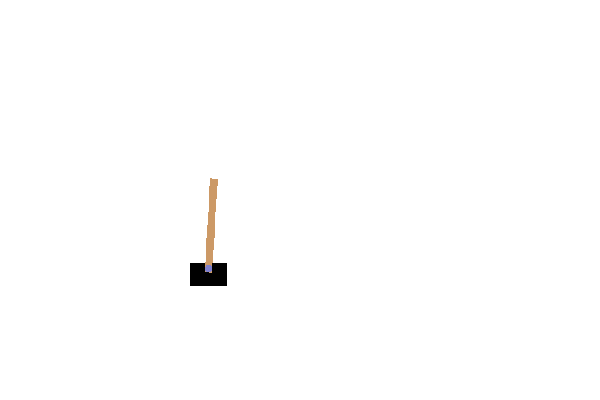
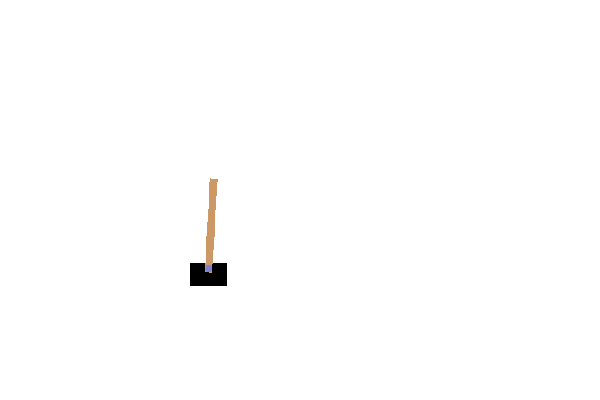
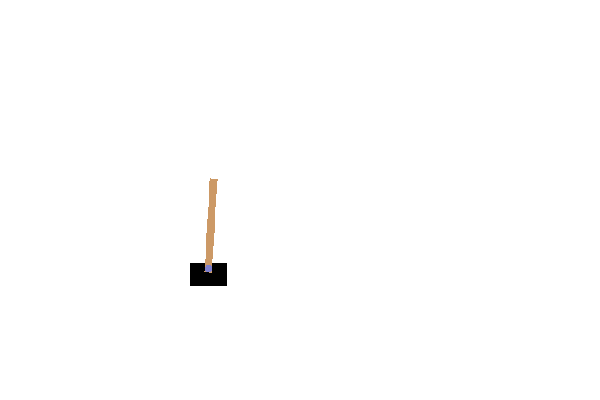
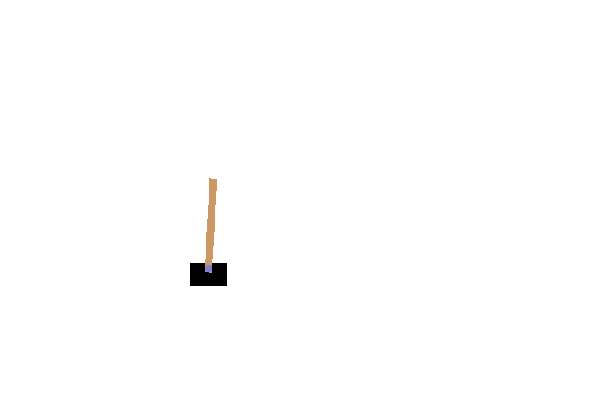
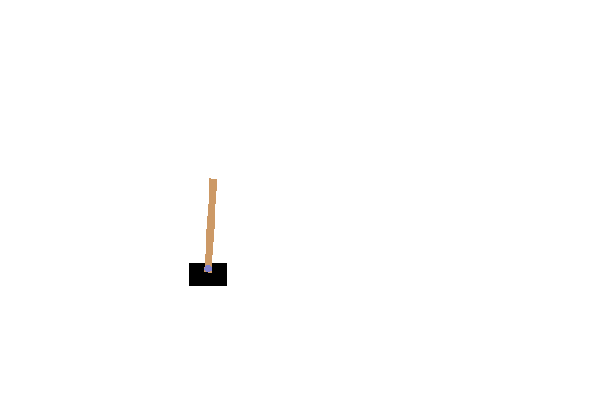
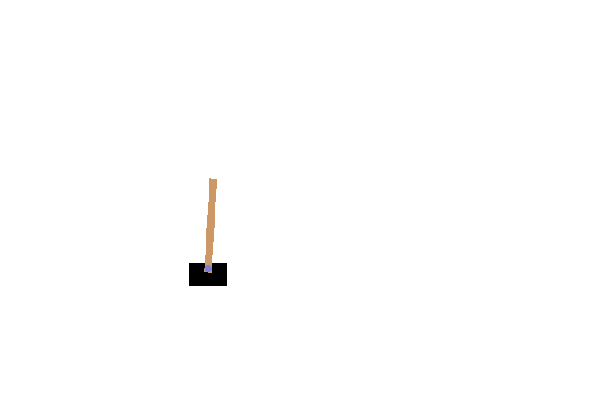
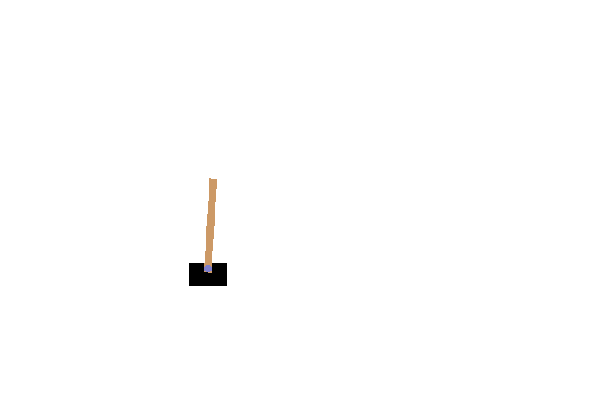
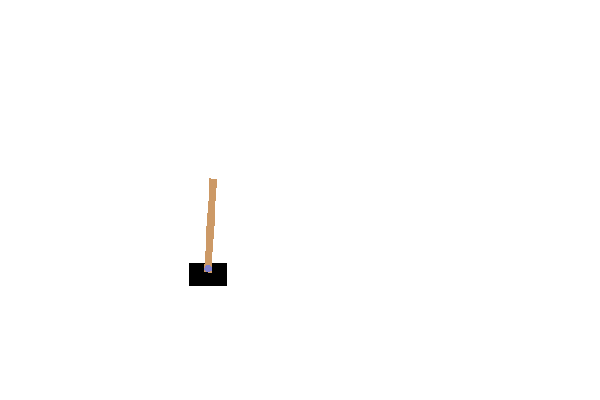
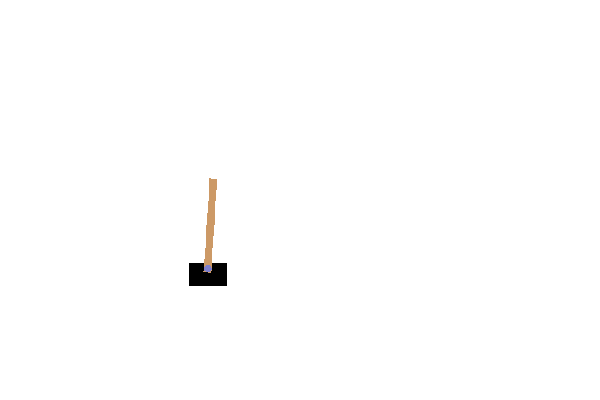
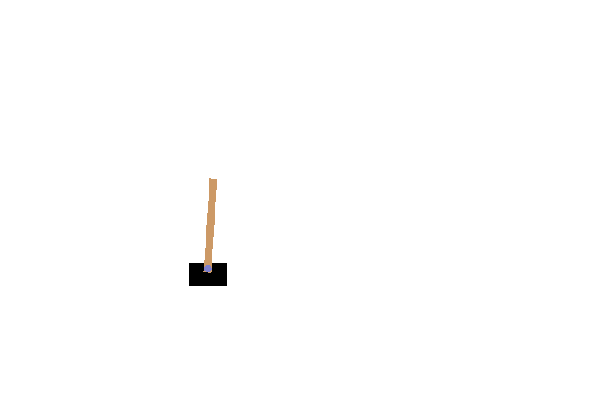
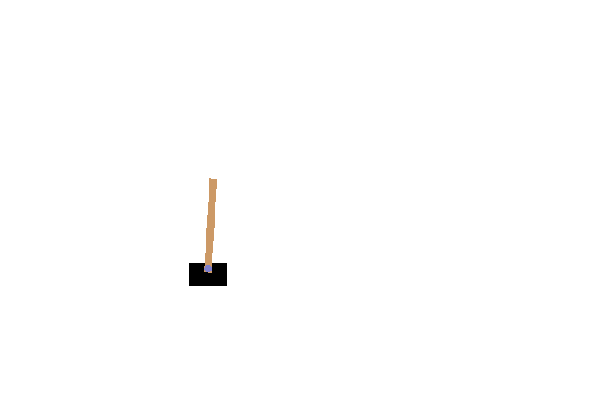
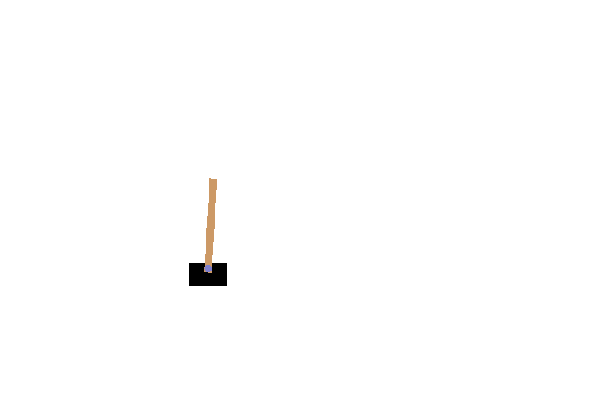
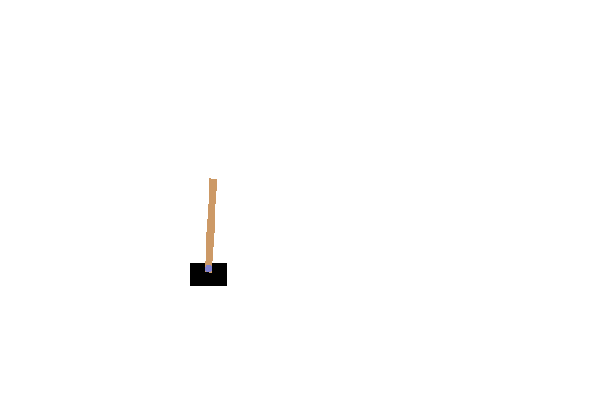
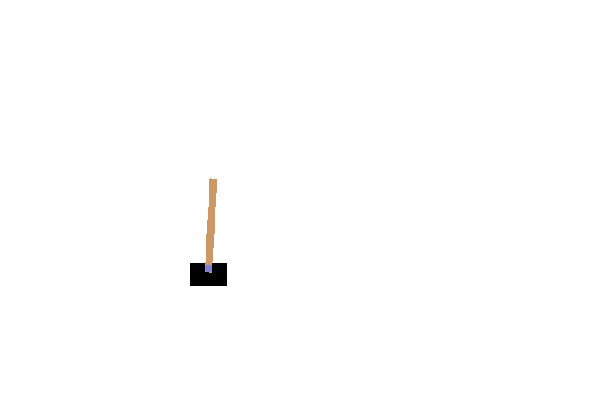

In [58]:
cart_env=Environment()
cart_env.run()